# Modeling TF-IDF + NB (MNB - Multinomial Naive Bayes) Notebook

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import (
    fbeta_score,
    make_scorer
)
from joblib import dump, load
from scipy.stats import loguniform, randint

root_path = Path.cwd().parents[1]  #go to root
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold
)
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**a) MNB basic preprocessed data**

In [4]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

MNB TPE basic

c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Best parameters found by Optuna TPE: {'alpha': 0.022294225239135424, 'fit_prior': True, 'select__k': 482, 'tfidf_use_idf': False, 'tfidf_sublinear_tf': True}
Best F2 score during optimization: 0.852

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


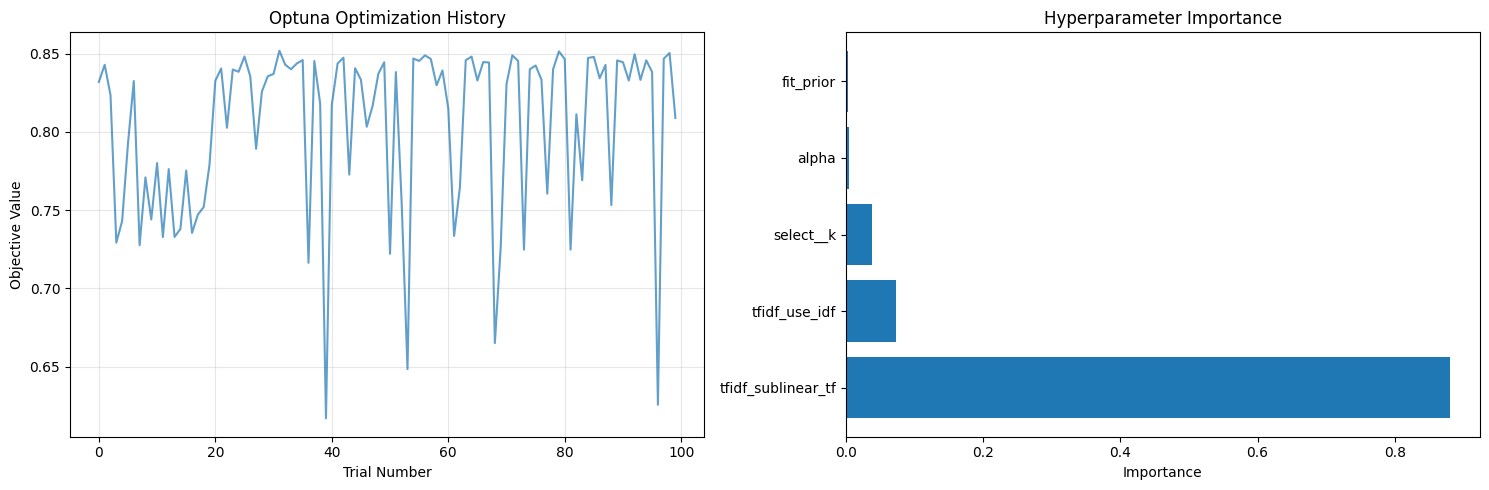


2. Parameter Value Distributions:


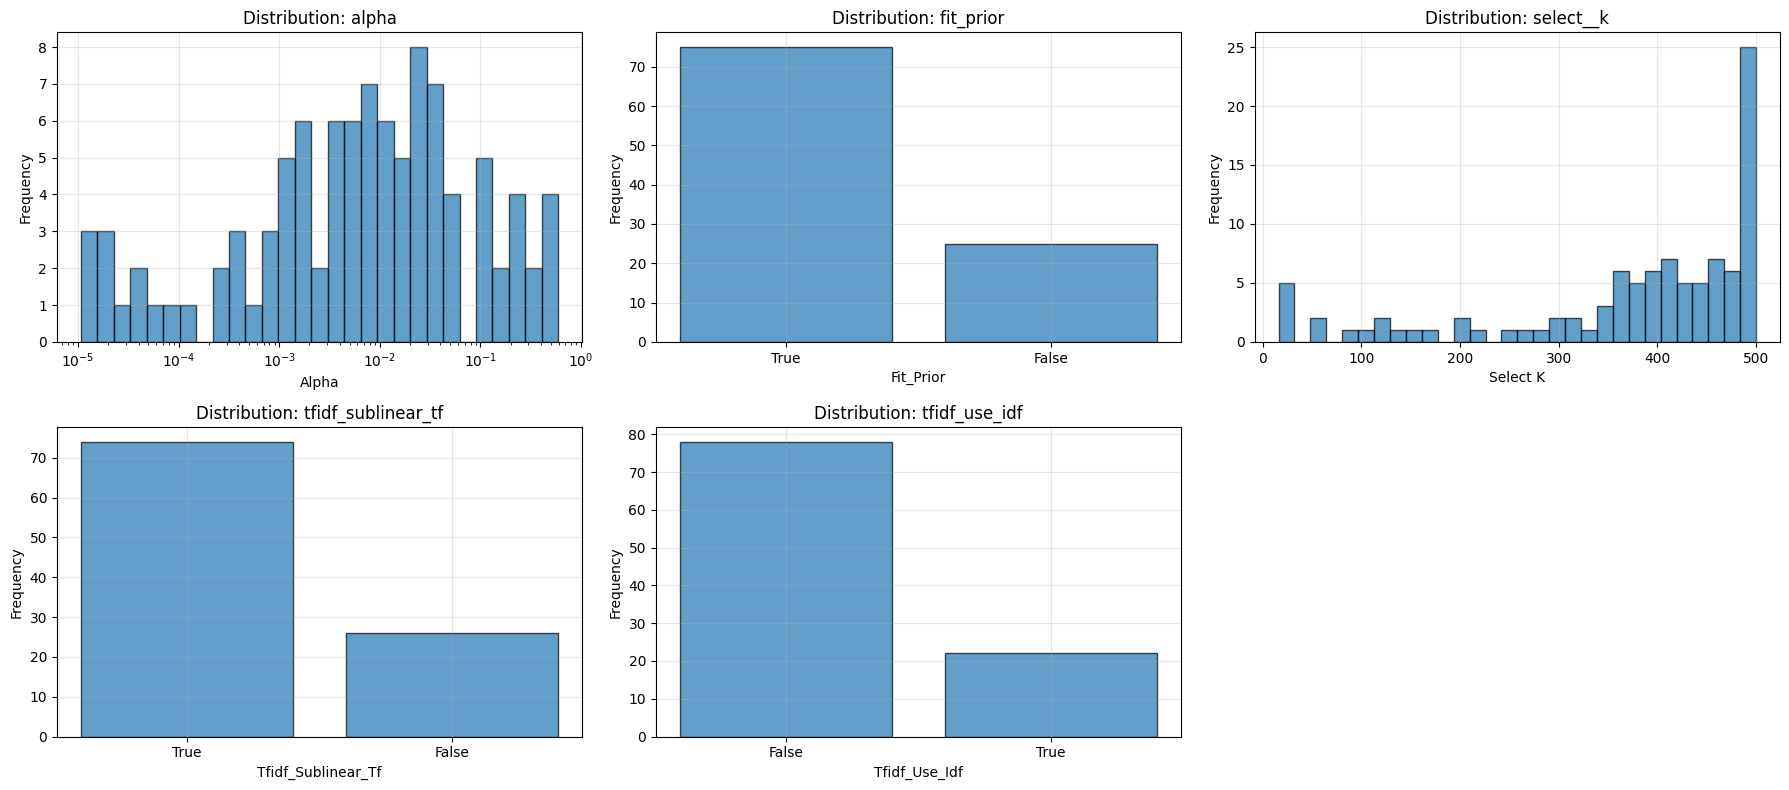


3. Performance vs Individual Parameters:


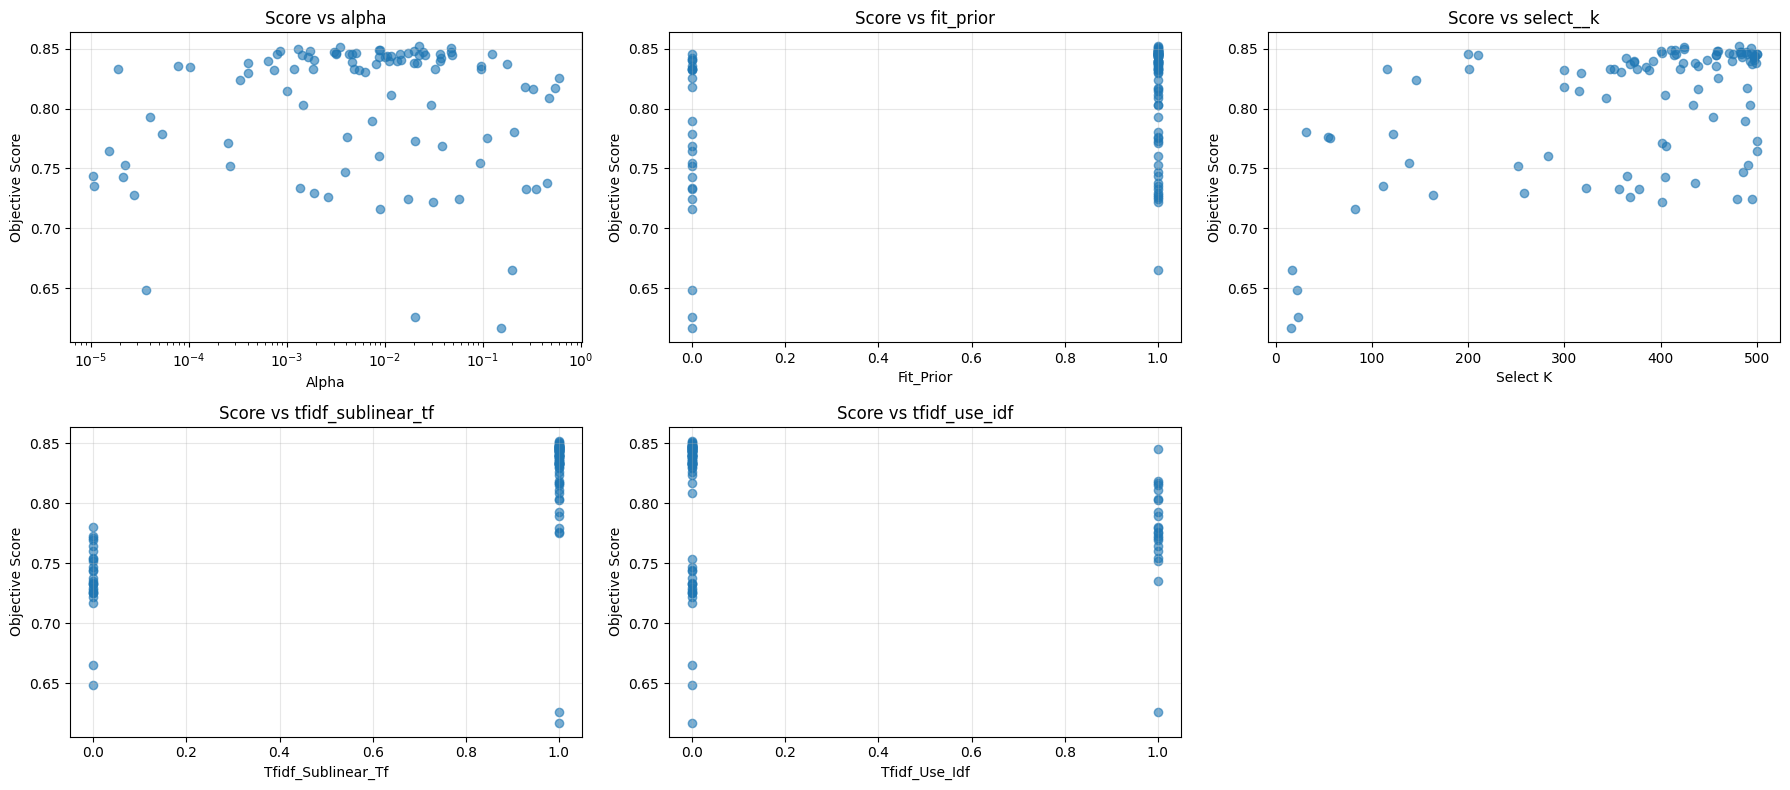


4. Convergence Analysis:


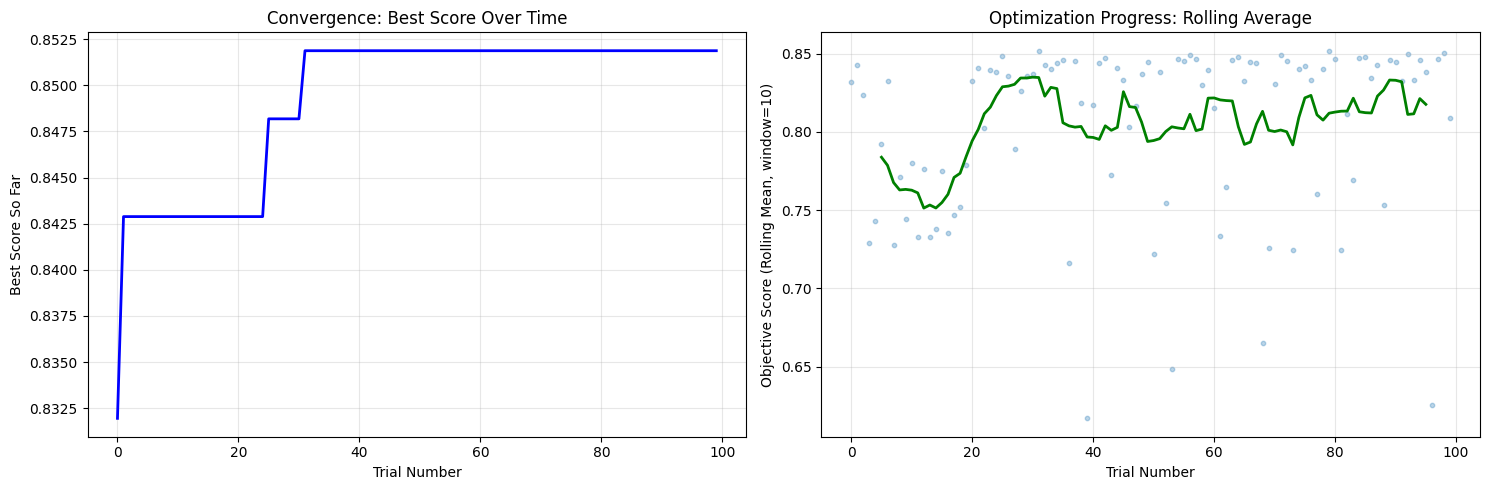


5. Trial Status Overview:


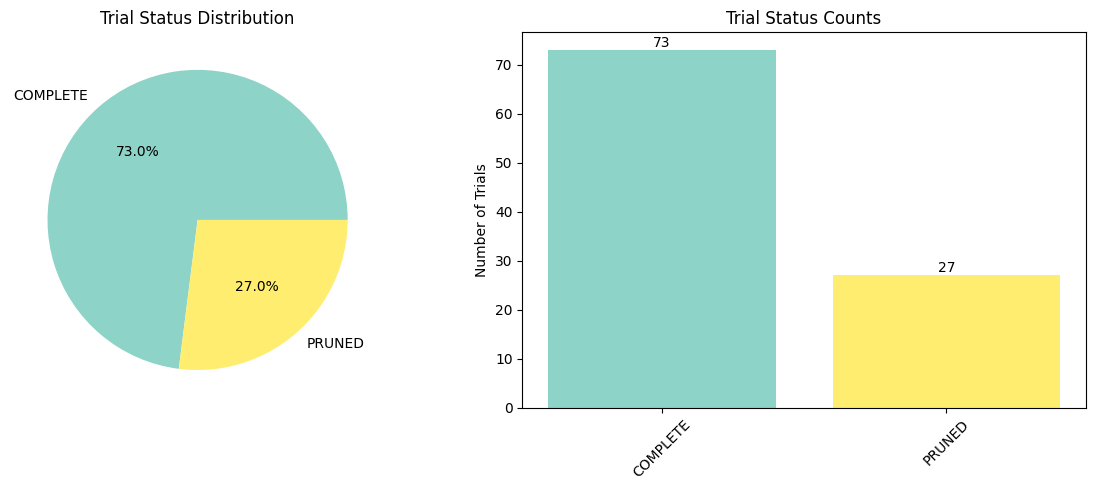


6. Top 10 Best Trials:
Rank Trial#  Score      alpha        fit_prior    k            tfidf_sublinear_tf tfidf_use_idf
-----------------------------------------------------------------------------------------------
1    31      0.8519     0.0223       True         482          True         False       
2    79      0.8515     0.0035       True         424          True         False       
3    98      0.8504     0.0472       True         494          True         False       
4    92      0.8496     0.0013       True         424          True         False       
5    56      0.8489     0.0087       True         415          True         False       
6    71      0.8489     0.0089       True         411          True         False       
7    25      0.8482     0.0197       True         459          True         False       
8    64      0.8481     0.0017       True         401          True         False       
9    85      0.8479     0.0008       True         460          True     

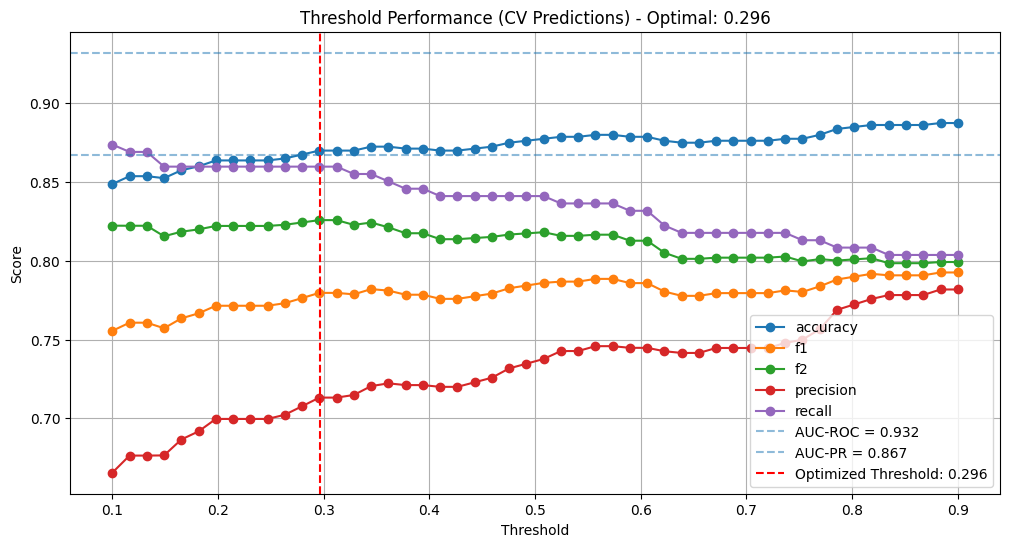

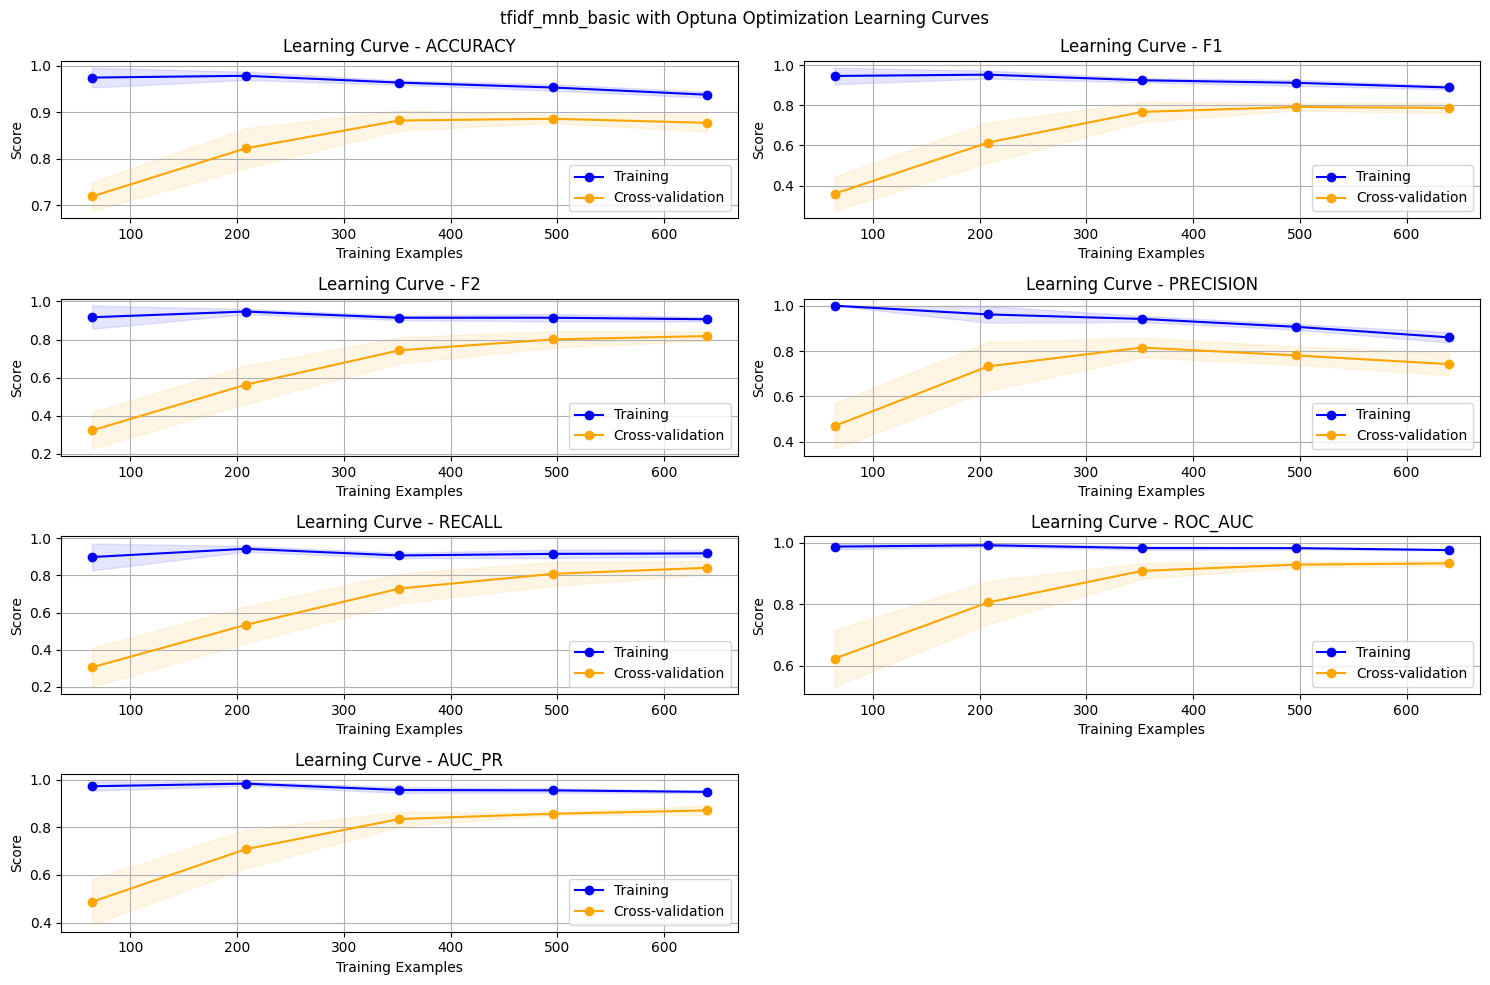


Final Threshold: 0.30

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       146
           1       0.71      0.78      0.74        54

    accuracy                           0.85       200
   macro avg       0.81      0.83      0.82       200
weighted avg       0.86      0.85      0.86       200

Additional Metrics:
Accuracy   0.855
F2-score   0.764
AUC-ROC    0.919
AUC-PR     0.824



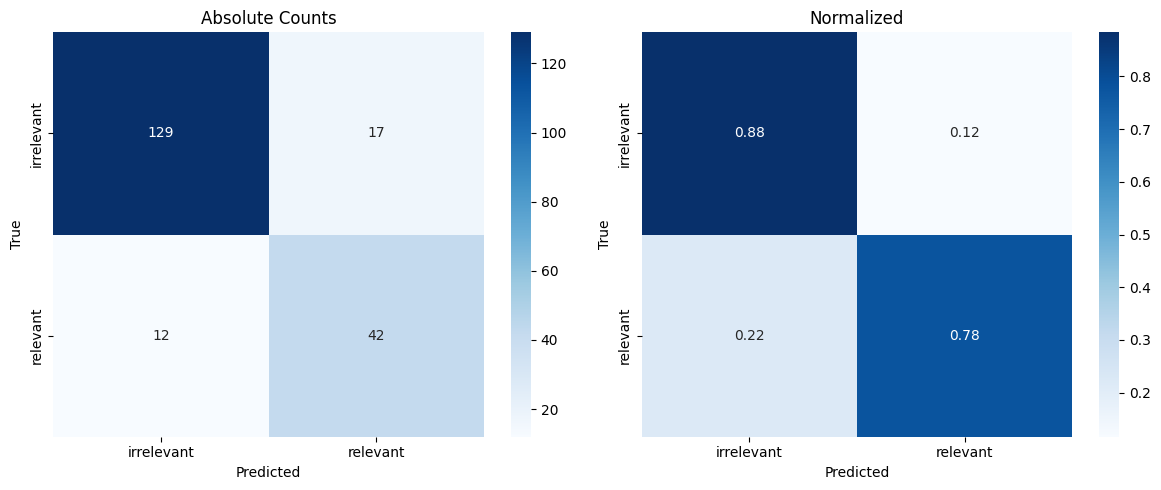

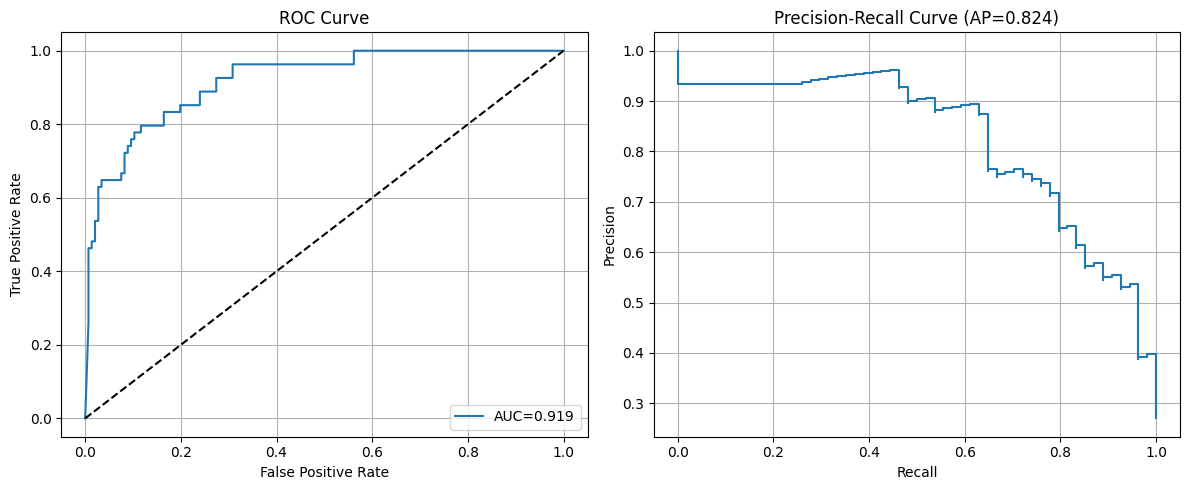


Model saved as model_tfidf_mnb_basic.joblib


In [14]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a MNB classifier 
pipeline_tfidf_mnb = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True, norm=None, use_idf=False, sublinear_tf=True)), #The multinomial distribution normally requires integer feature counts. sklearn
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     MultinomialNB(
                    alpha=1.0, #will be optimized during optuna
                    fit_prior=False, #will be optimized during optuna    
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter space for Optuna optimization
param_space = {
    "clf__alpha": lambda trial: trial.suggest_float("alpha", 1e-5, 1.0, log=True),
    "clf__fit_prior": lambda trial: trial.suggest_categorical("fit_prior", [True, False]),
    "select__k": lambda trial: trial.suggest_int("select__k", 1, 500, step=1),
    "tfidf__use_idf":      lambda t: t.suggest_categorical("tfidf_use_idf", [False, True]),
    "tfidf__sublinear_tf": lambda t: t.suggest_categorical("tfidf_sublinear_tf", [False, True]),
}

model_name = "tfidf_mnb_basic"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_tfidf_mnb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "naive_bayes",
    n_trials=100,  # Intelligent search with early stopping
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1] #predict_proba available for MNB

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1] #predict_proba available for MNB
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

GS MNB basic

Best parameters found by Optuna TPE: {'clf__alpha': 0.01, 'select__k': 520, 'clf__fit_prior': True, 'tfidf__use_idf': False, 'tfidf__sublinear_tf': True}
Best F2 score during optimization: 0.853

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


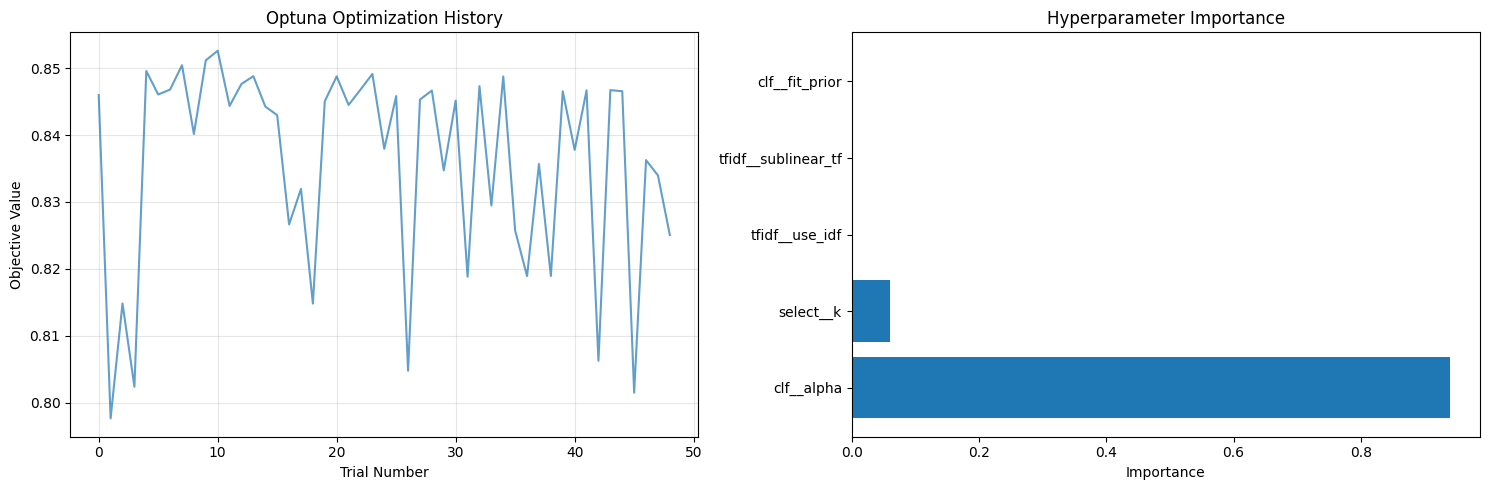


2. Parameter Value Distributions:


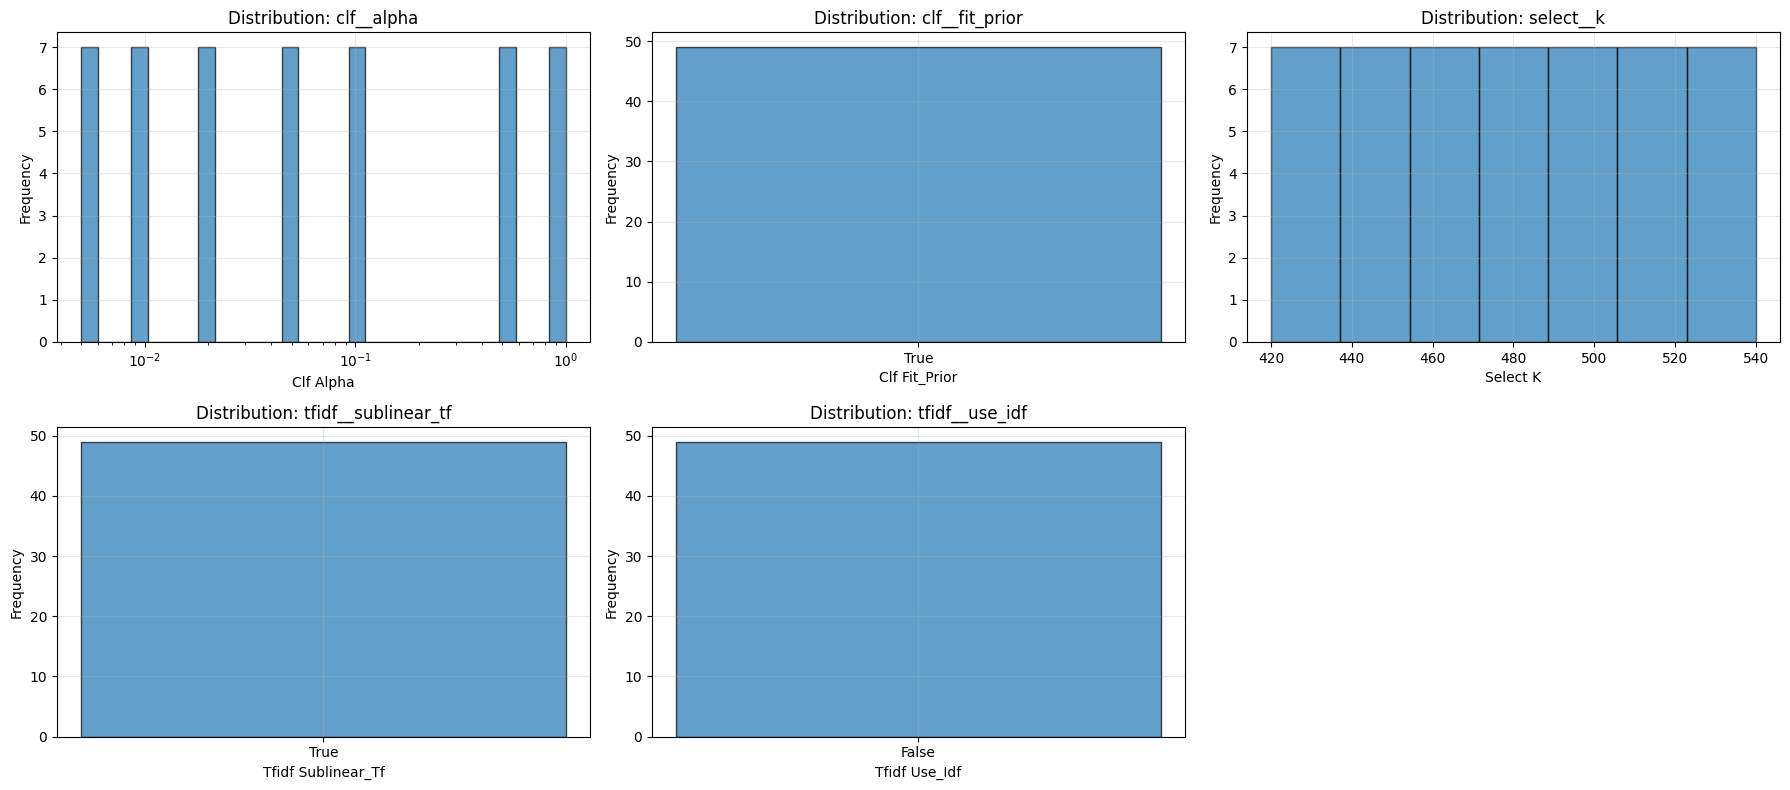


3. Performance vs Individual Parameters:


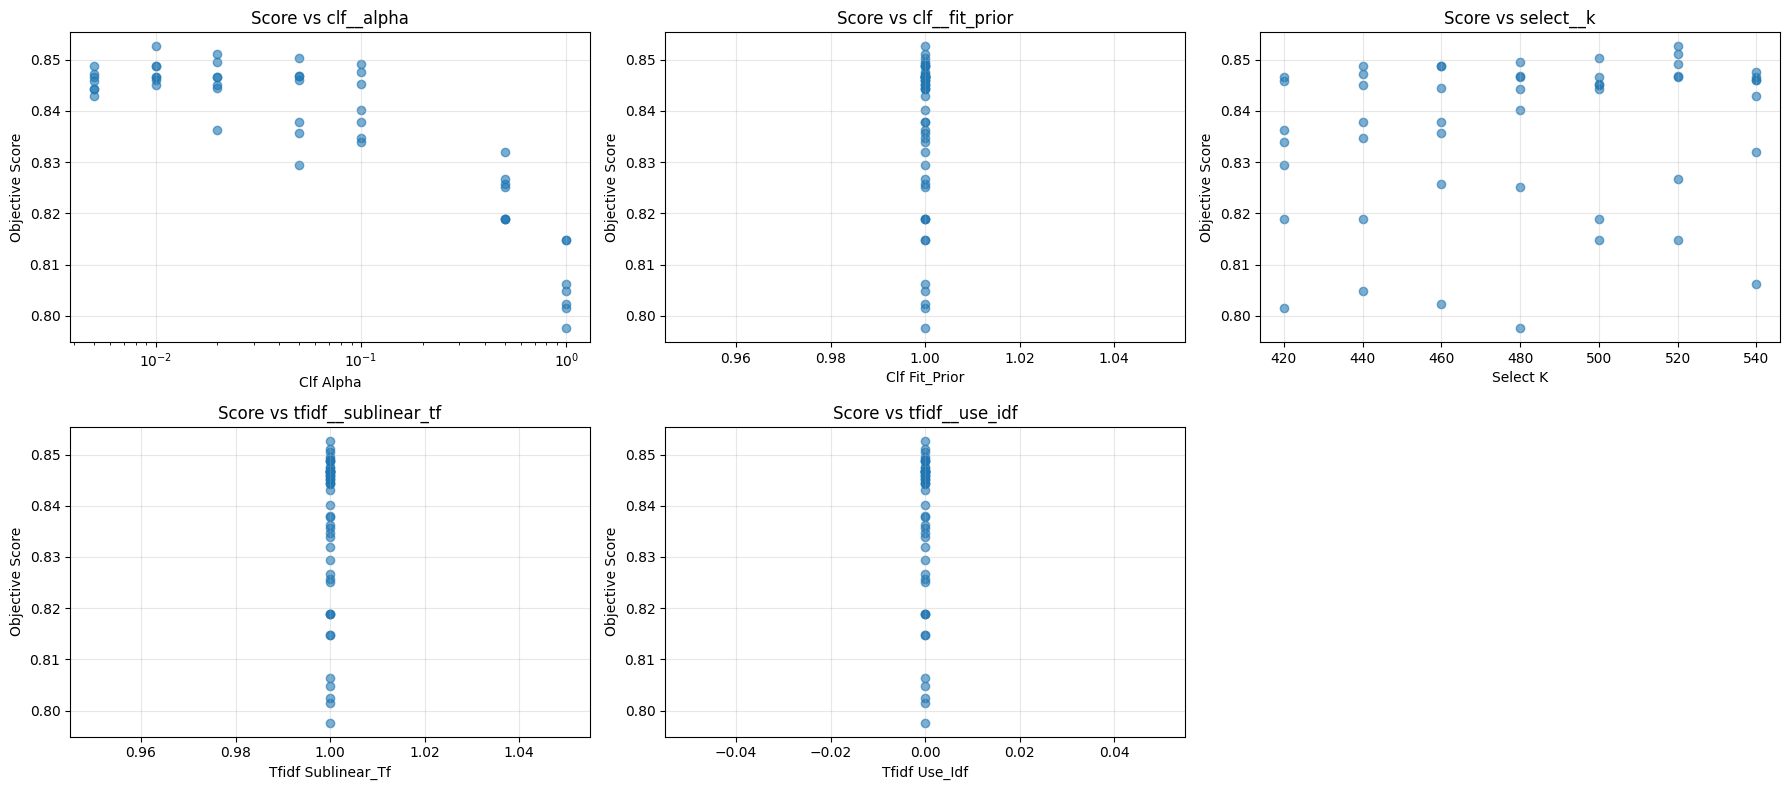


4. Convergence Analysis:


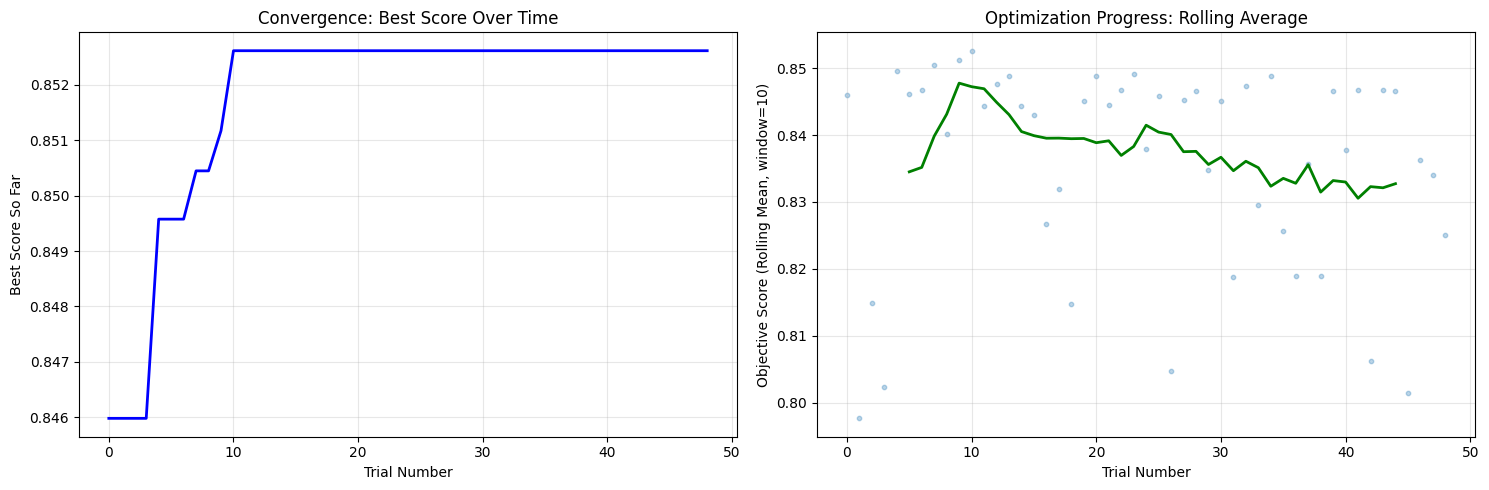


5. Trial Status Overview:


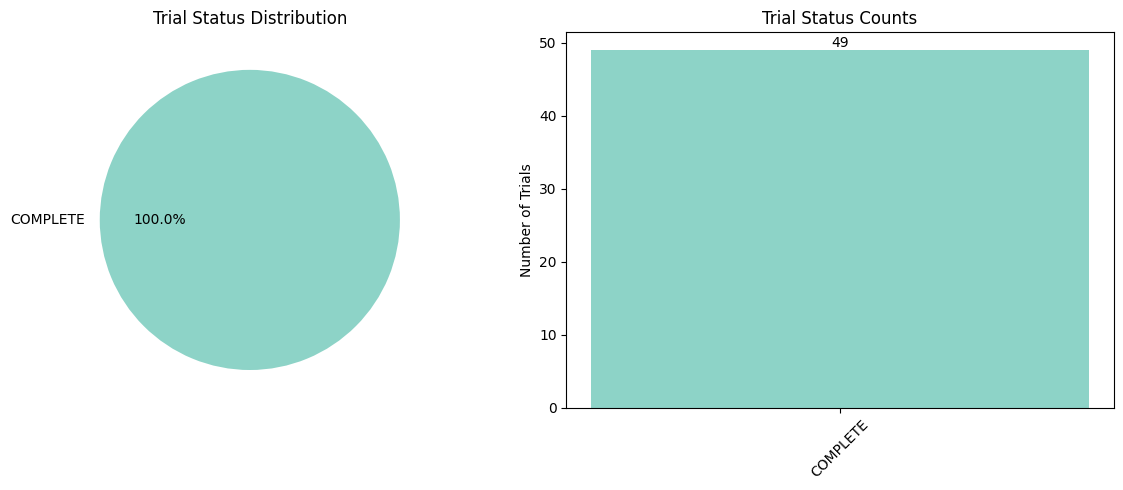


6. Top 10 Best Trials:
Rank Trial#  Score      alpha        fit_prior    k            sublinear_tf use_idf     
----------------------------------------------------------------------------------------
1    10      0.8526     0.0100       True         520          True         False       
2    9       0.8512     0.0200       True         520          True         False       
3    7       0.8504     0.0500       True         500          True         False       
4    4       0.8496     0.0200       True         480          True         False       
5    23      0.8491     0.1000       True         520          True         False       
6    13      0.8488     0.0100       True         440          True         False       
7    20      0.8488     0.0100       True         460          True         False       
8    34      0.8488     0.0050       True         460          True         False       
9    12      0.8477     0.1000       True         540          True         False     

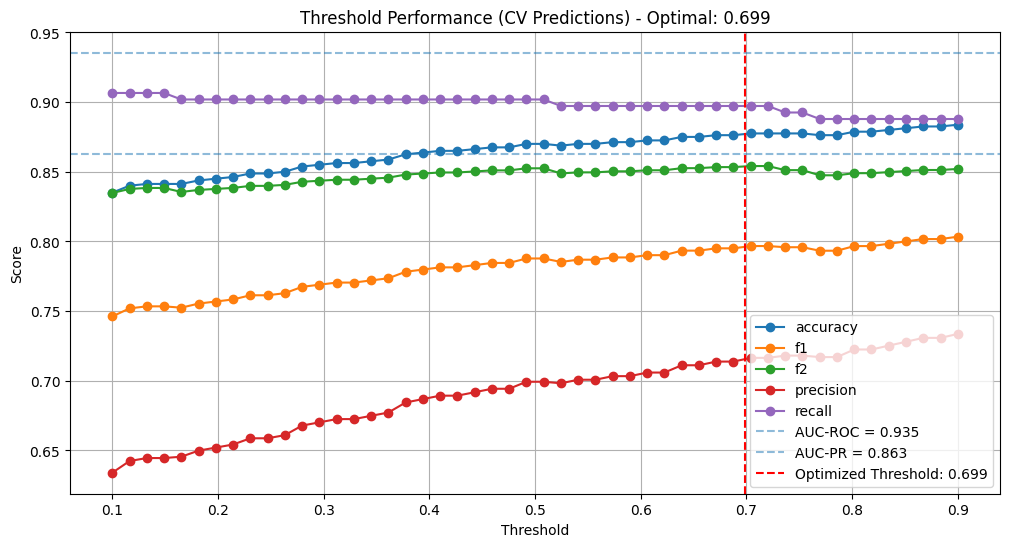

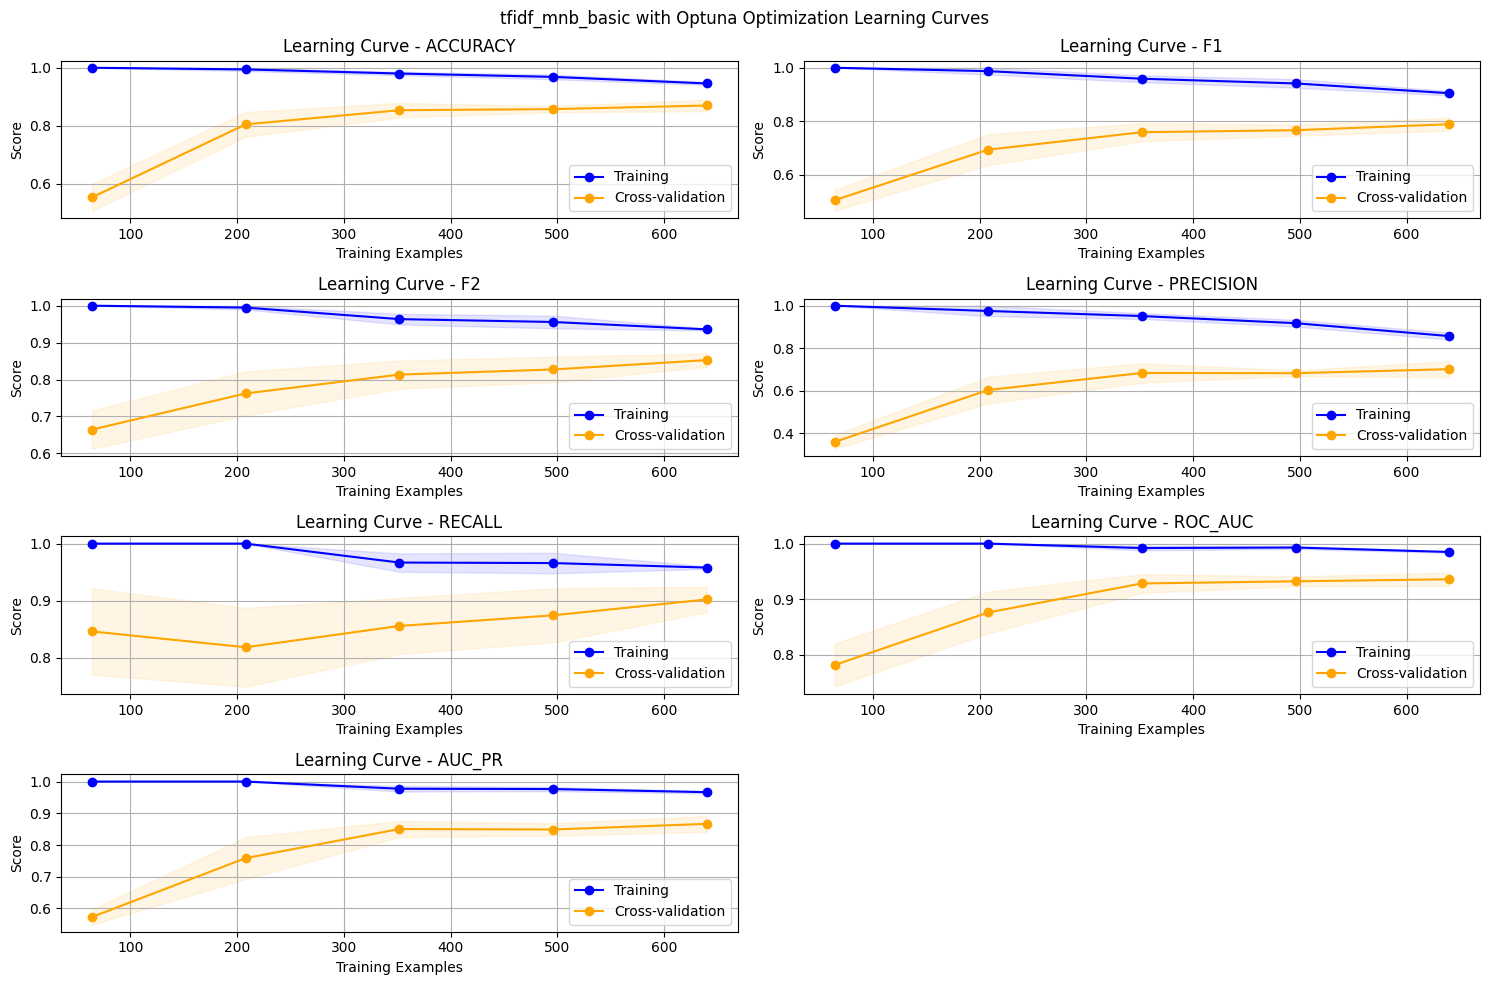


Final Threshold: 0.70

Test Set Performance:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       146
           1       0.70      0.80      0.75        54

    accuracy                           0.85       200
   macro avg       0.81      0.84      0.82       200
weighted avg       0.86      0.85      0.86       200

Additional Metrics:
Accuracy   0.855
F2-score   0.776
AUC-ROC    0.931
AUC-PR     0.830



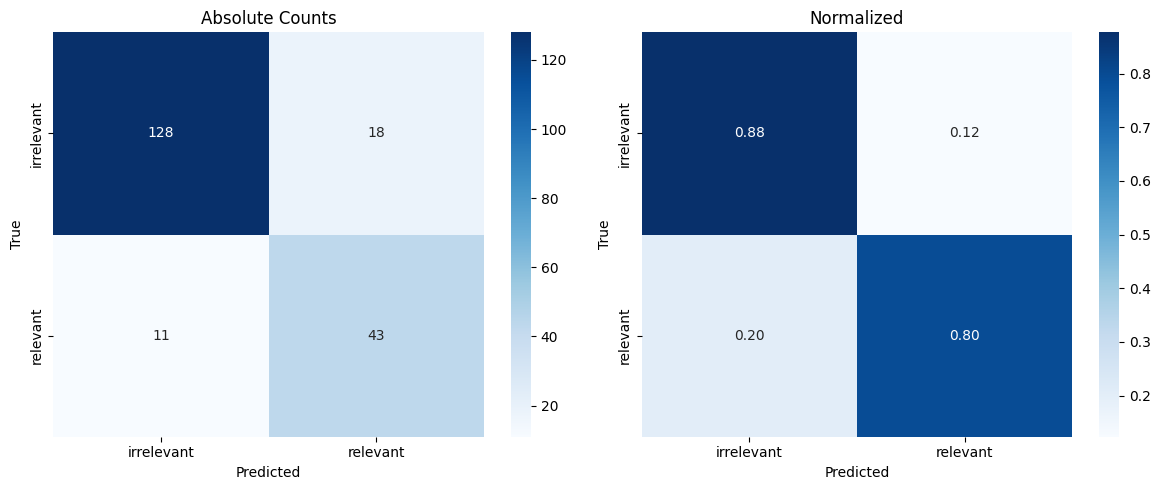

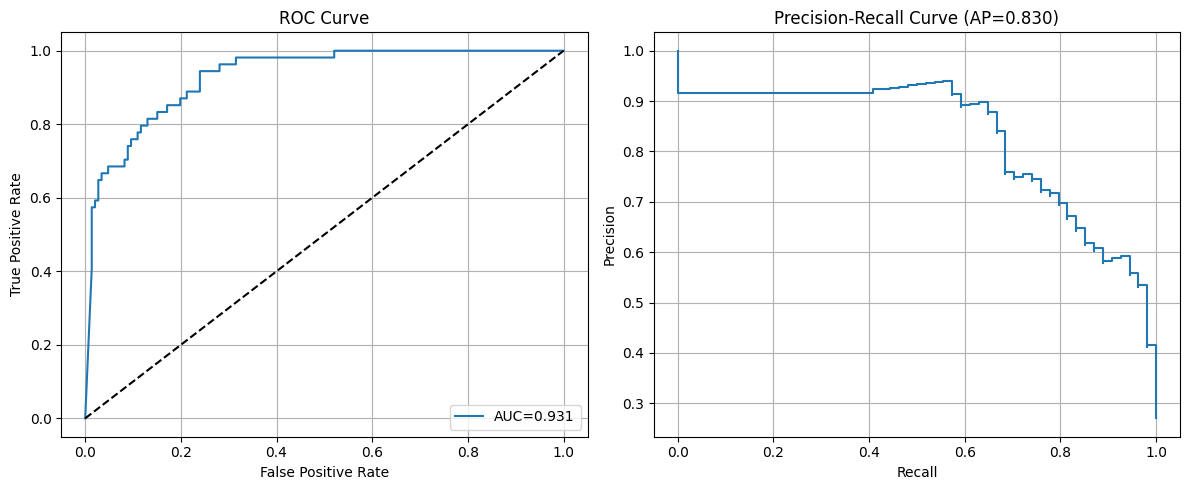


Model saved as model_tfidf_mnb_basic.joblib


In [21]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a MNB classifier 
pipeline_tfidf_mnb = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True, norm=None, use_idf=False, sublinear_tf=True)), #The multinomial distribution normally requires integer feature counts. sklearn
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     MultinomialNB(
                    alpha=1.0, #will be optimized during optuna
                    fit_prior=False, #will be optimized during optuna    
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "clf__alpha": [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1.0],   # log-spaced sweep centered near TPE best (~0.02) with high-end scouts
    "select__k":  [420, 440, 460, 480, 500, 520, 540],        # high-k cluster from TPE (≈400–500) + upper scouts (520, 540)
    "clf__fit_prior": [True],                                 # consistently True in top trials → lock
    "tfidf__use_idf": [False],                                # top trials use raw TF (no IDF) → lock
    "tfidf__sublinear_tf": [True],                            # strongest importance; almost always True → lock
}
model_name = "tfidf_mnb_basic"

#for second search with grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_tfidf_mnb,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1] #predict_proba available for MNB

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1] #predict_proba available for MNB
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

**b) MNB advanced preprocessed data**

In [16]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # advanced cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

MNB TPE advanced

c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Best parameters found by Optuna TPE: {'alpha': 0.0035418797035476307, 'fit_prior': False, 'select__k': 419, 'tfidf_use_idf': False, 'tfidf_sublinear_tf': True, 'phrases__enable': False, 'phrases__min_count': 80, 'phrases__threshold': 5.249590848713853}
Best F2 score during optimization: 0.851

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


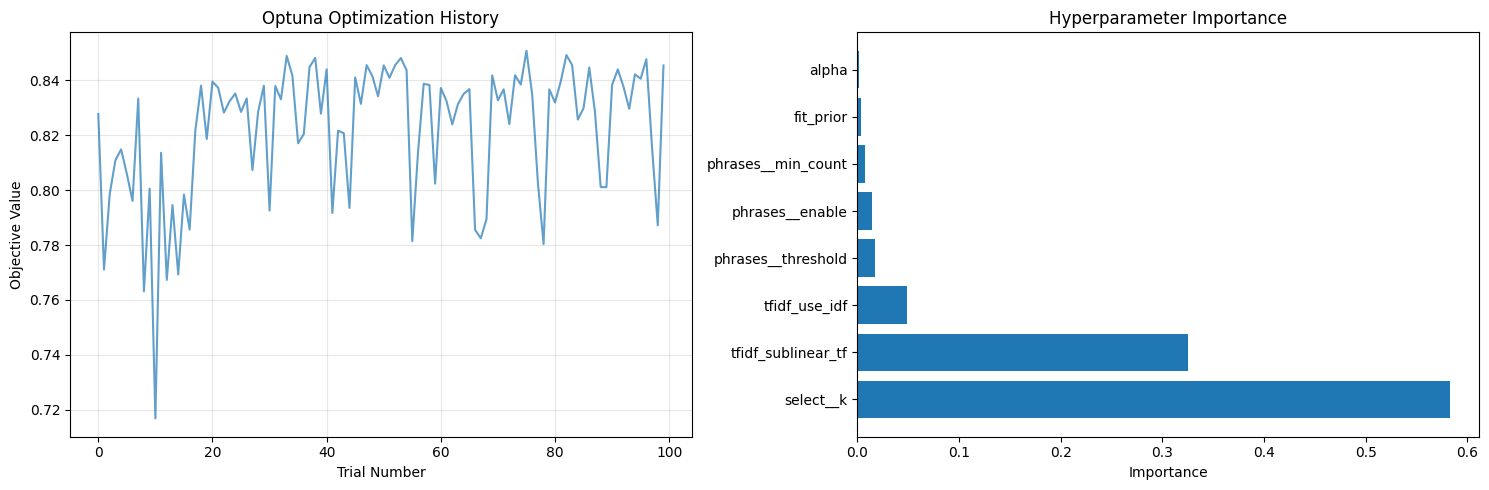


2. Parameter Value Distributions:


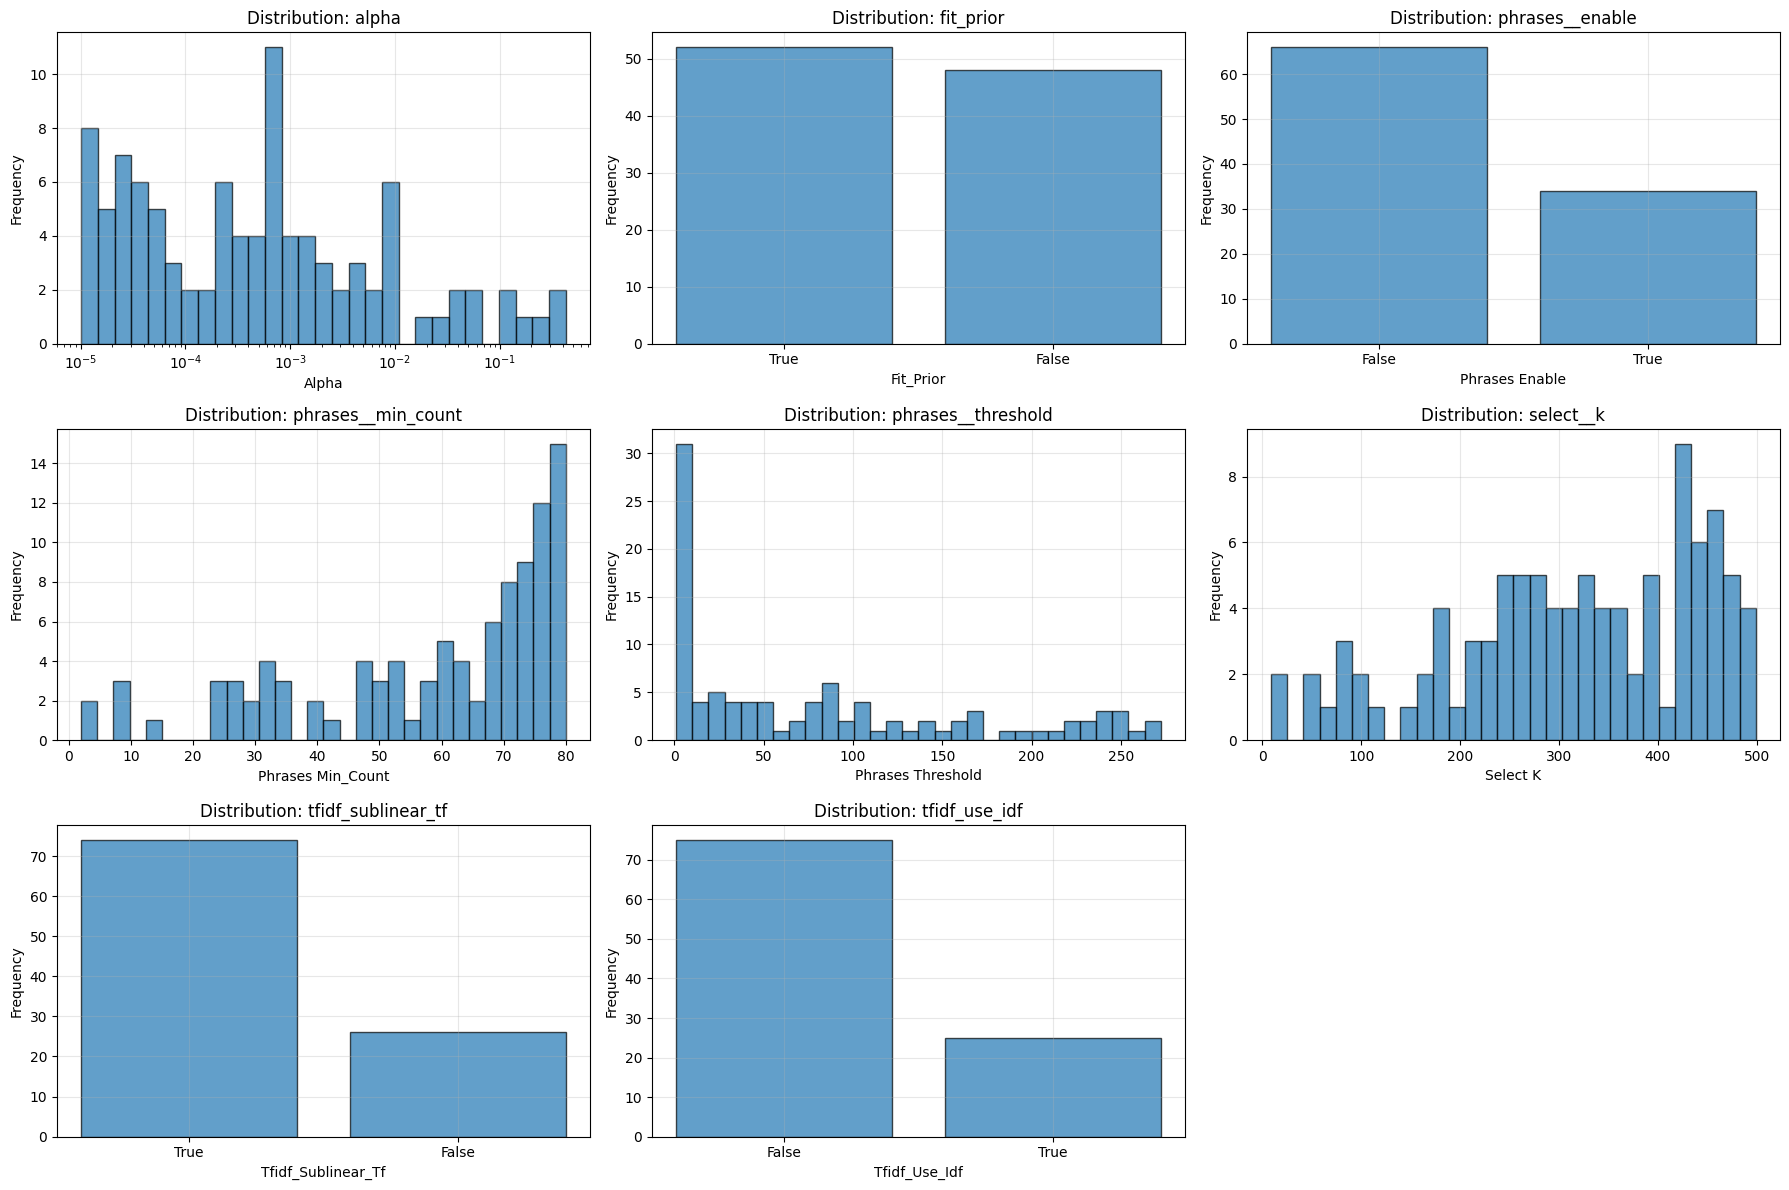


3. Performance vs Individual Parameters:


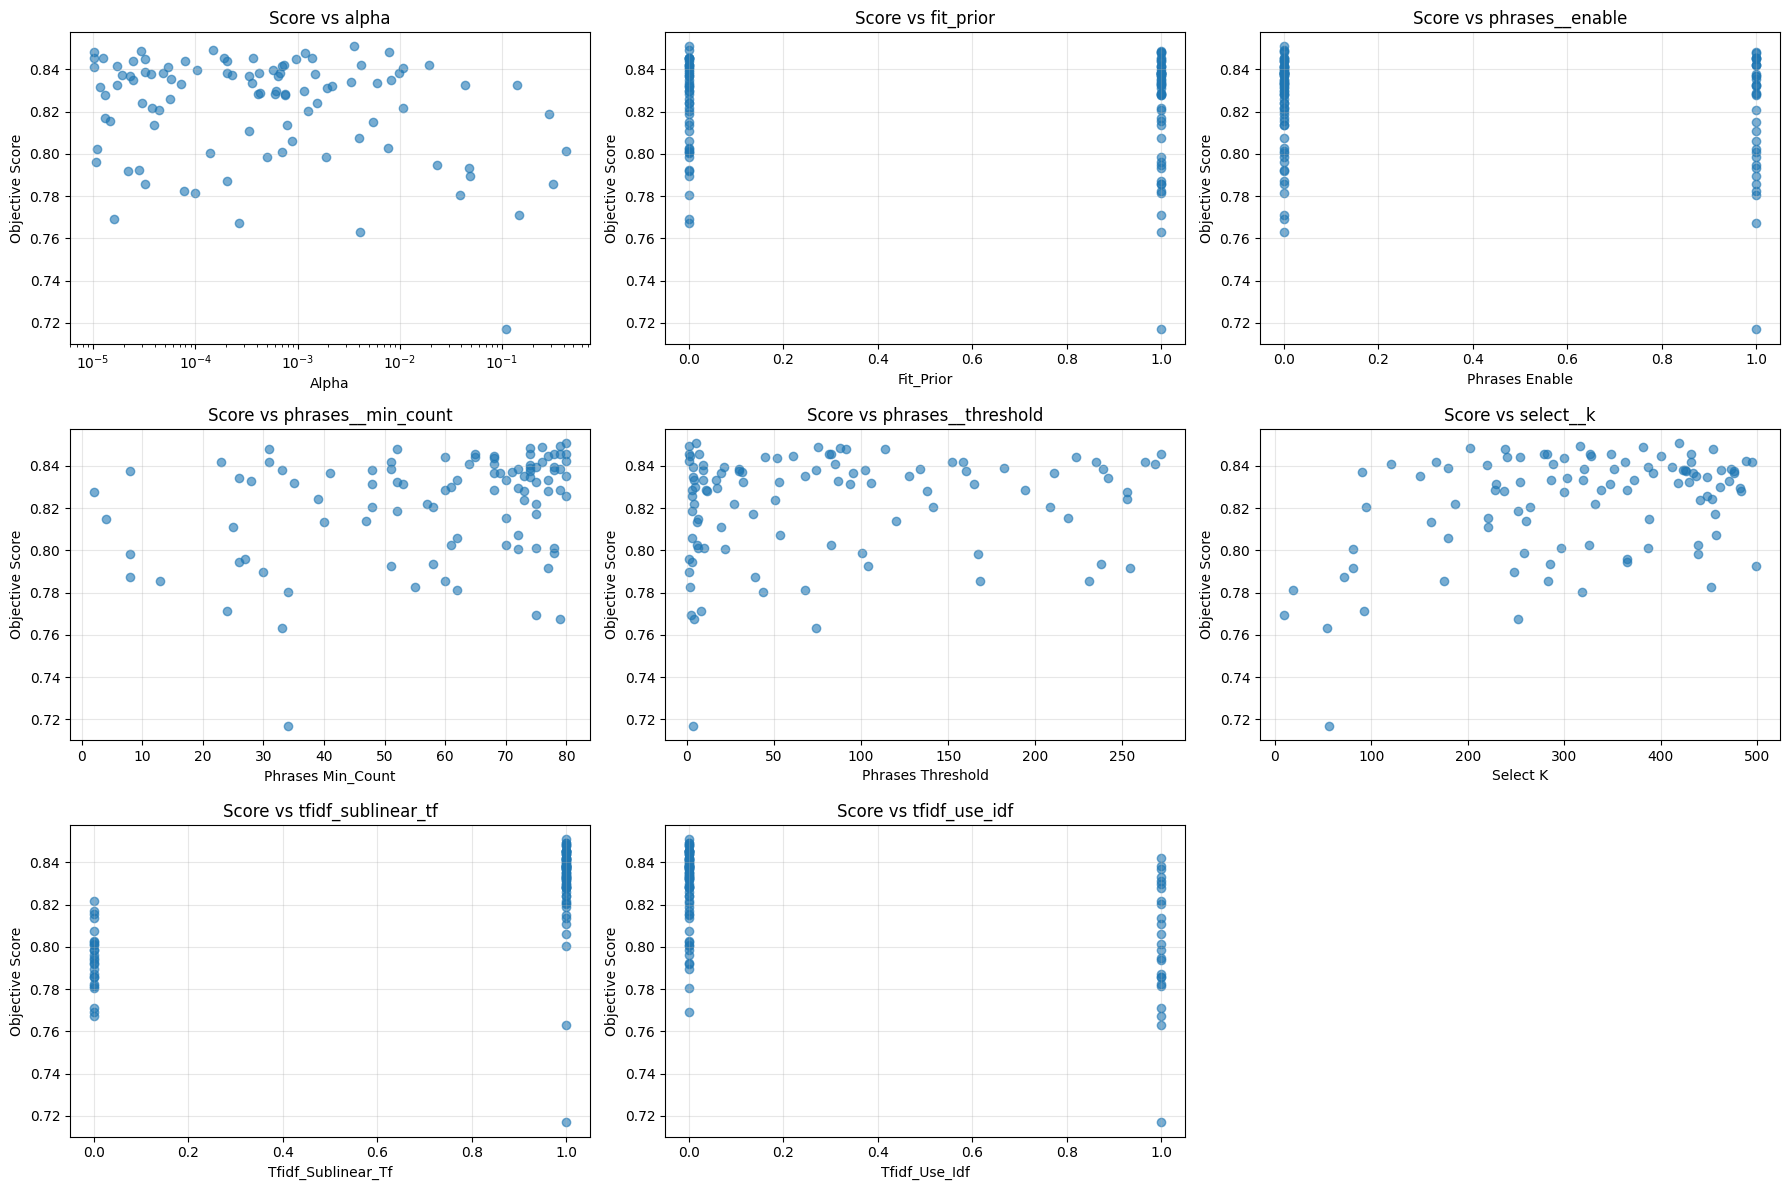


4. Convergence Analysis:


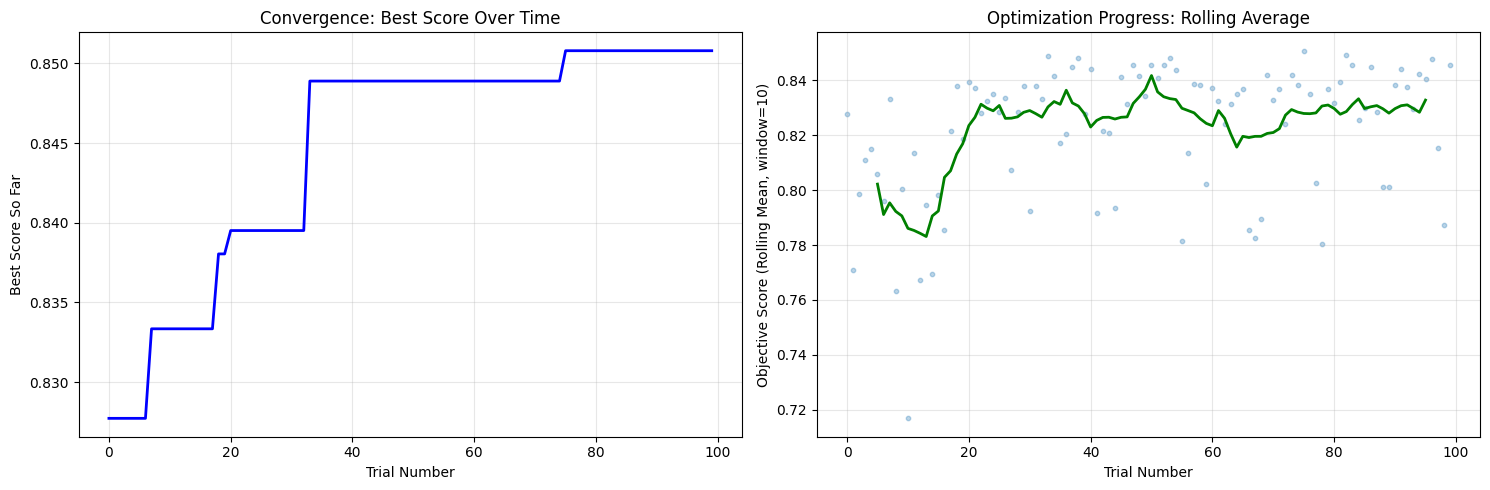


5. Trial Status Overview:


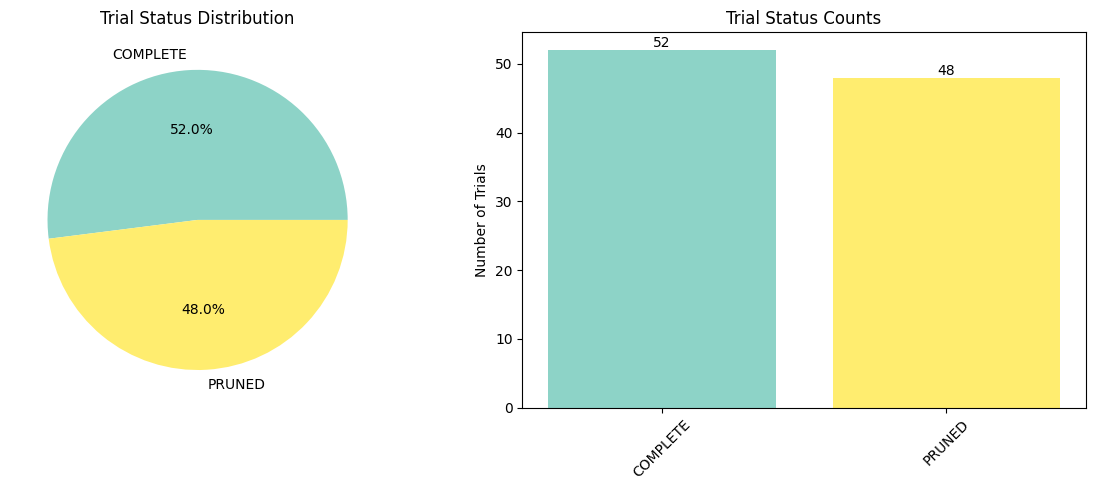


6. Top 10 Best Trials:
Rank Trial#  Score      alpha        fit_prior    enable       min_count    threshold    k            tfidf_sublinear_tf tfidf_use_idf
--------------------------------------------------------------------------------------------------------------------------------------
1    75      0.8508     0.0035       False        False        80           5.2496       419          True         False       
2    82      0.8492     0.0001       False        False        79           1.4075       316          True         False       
3    33      0.8489     0.0000       True         False        76           75.5594      381          True         False       
4    38      0.8482     0.0000       True         False        74           88.0288      202          True         False       
5    53      0.8481     0.0078       True         True         52           113.9778     238          True         False       
6    96      0.8477     0.0012       True         True         31 

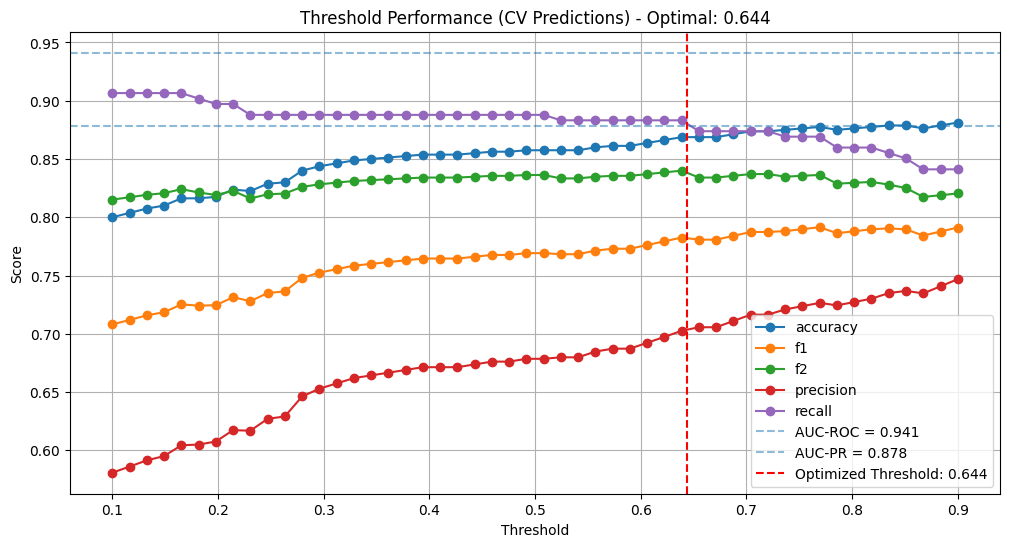

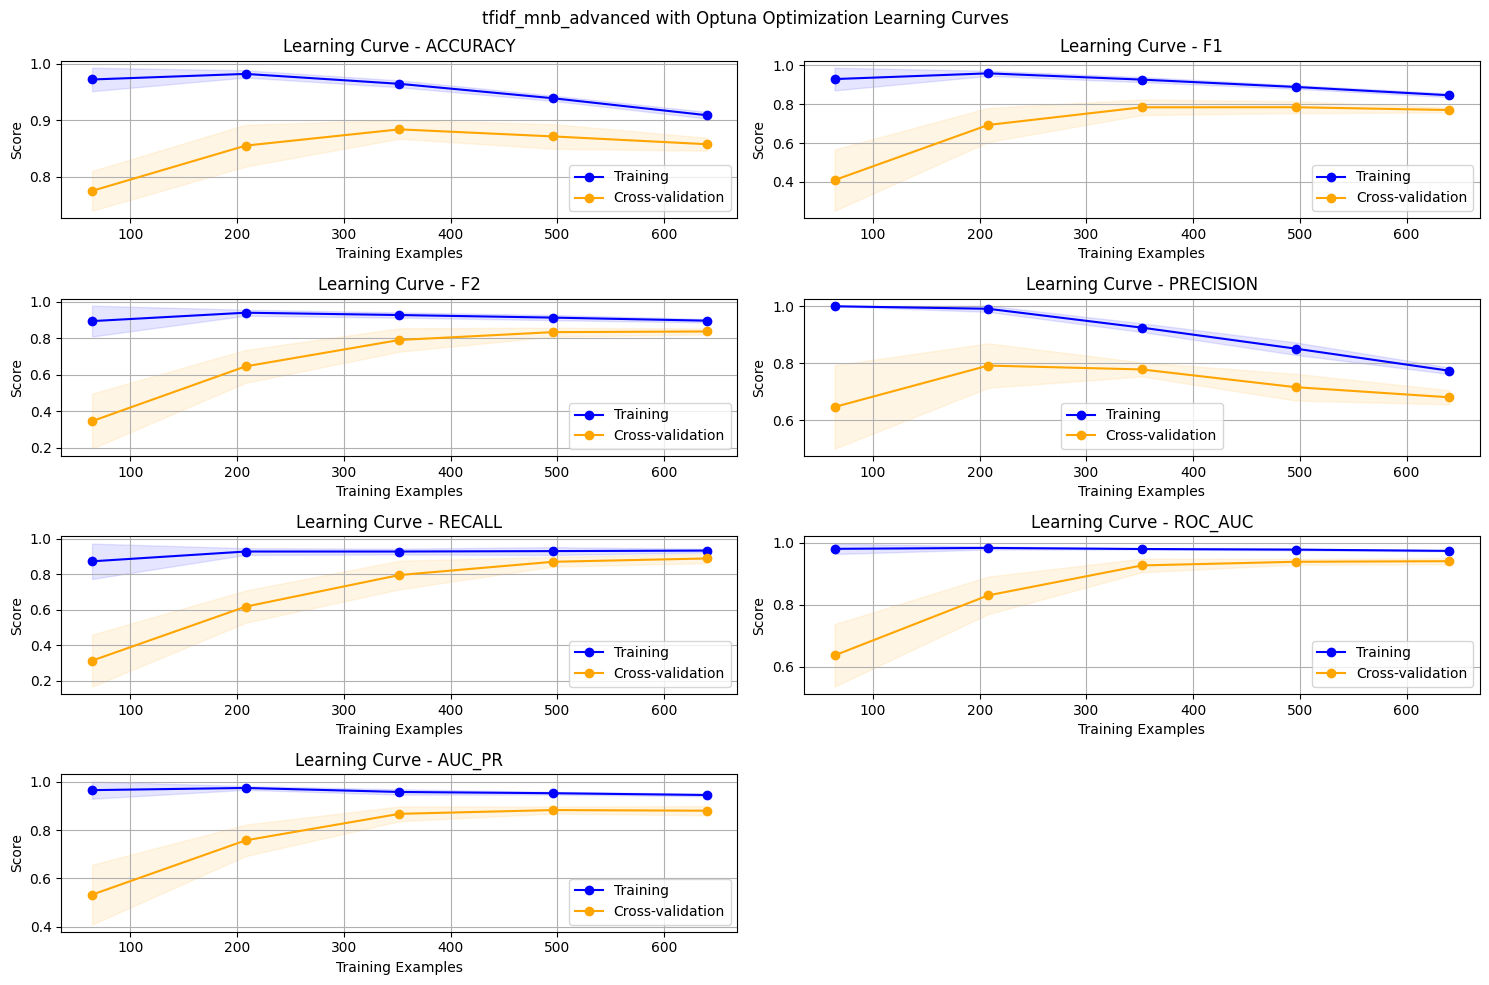


Final Threshold: 0.64
F2-score with default threshold (0.5): 0.854

Test Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       146
           1       0.70      0.89      0.78        54

    accuracy                           0.86       200
   macro avg       0.82      0.87      0.84       200
weighted avg       0.88      0.86      0.87       200

Additional Metrics:
Accuracy   0.865
F2-score   0.842
AUC-ROC    0.934
AUC-PR     0.848



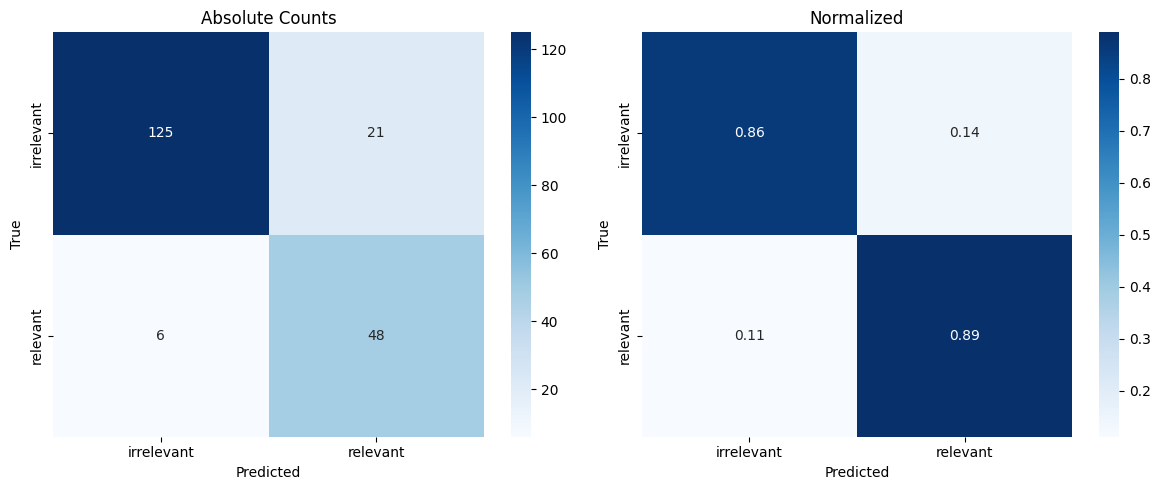

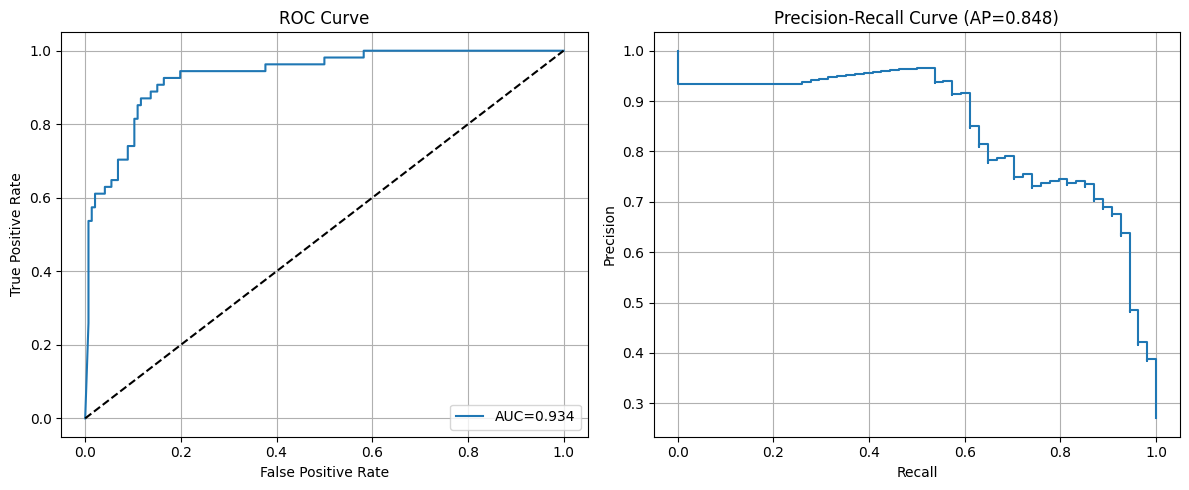


Model saved as model_tfidf_mnb_advanced.joblib


In [23]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a MNB classifier 
pipeline_tfidf_mnb = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True, norm=None, use_idf=False, sublinear_tf=True)), #The multinomial distribution normally requires integer feature counts. sklearn
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     MultinomialNB(
                    alpha=1.0, #will be optimized during optuna
                    fit_prior=True, #will be optimized during optuna    
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_space = {
    "clf__alpha": lambda trial: trial.suggest_float("alpha", 1e-5, 1, log=True),
    "clf__fit_prior": lambda trial: trial.suggest_categorical("fit_prior", [True, False]),
    "select__k": lambda trial: trial.suggest_int("select__k", 1, 500, step=1),
    "tfidf__use_idf":      lambda t: t.suggest_categorical("tfidf_use_idf", [False, True]),
    "tfidf__sublinear_tf": lambda t: t.suggest_categorical("tfidf_sublinear_tf", [False, True]),
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [False, True]),
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 1, 80),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 1.0, 300.0, log=True)
}

model_name = "tfidf_mnb_advanced"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_tfidf_mnb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type="naive_bayes",
    n_trials=100,  # Intelligent search with prunning
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name  # This will create optuna_log_{model_name}.txt
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

advanced MNB GridSearch

Best parameters found by Optuna TPE: {'clf__alpha': 0.001, 'select__k': 380, 'clf__fit_prior': True, 'tfidf__use_idf': False, 'tfidf__sublinear_tf': True, 'phrases__enable': False, 'phrases__min_count': 0, 'phrases__threshold': 0}
Best F2 score during optimization: 0.852

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


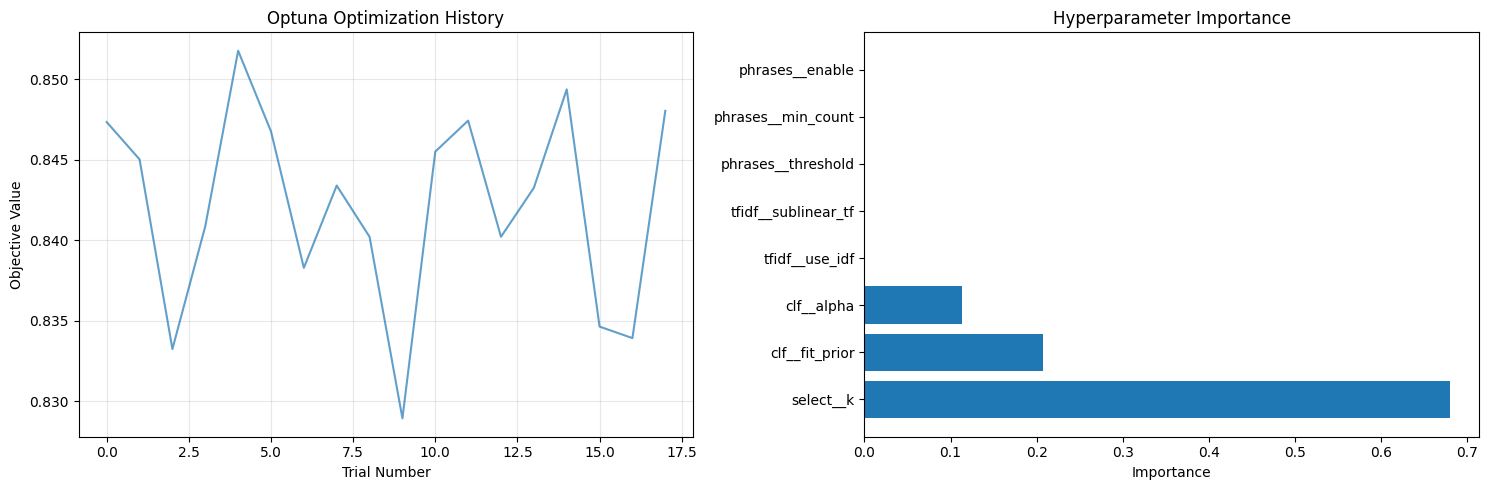


2. Parameter Value Distributions:


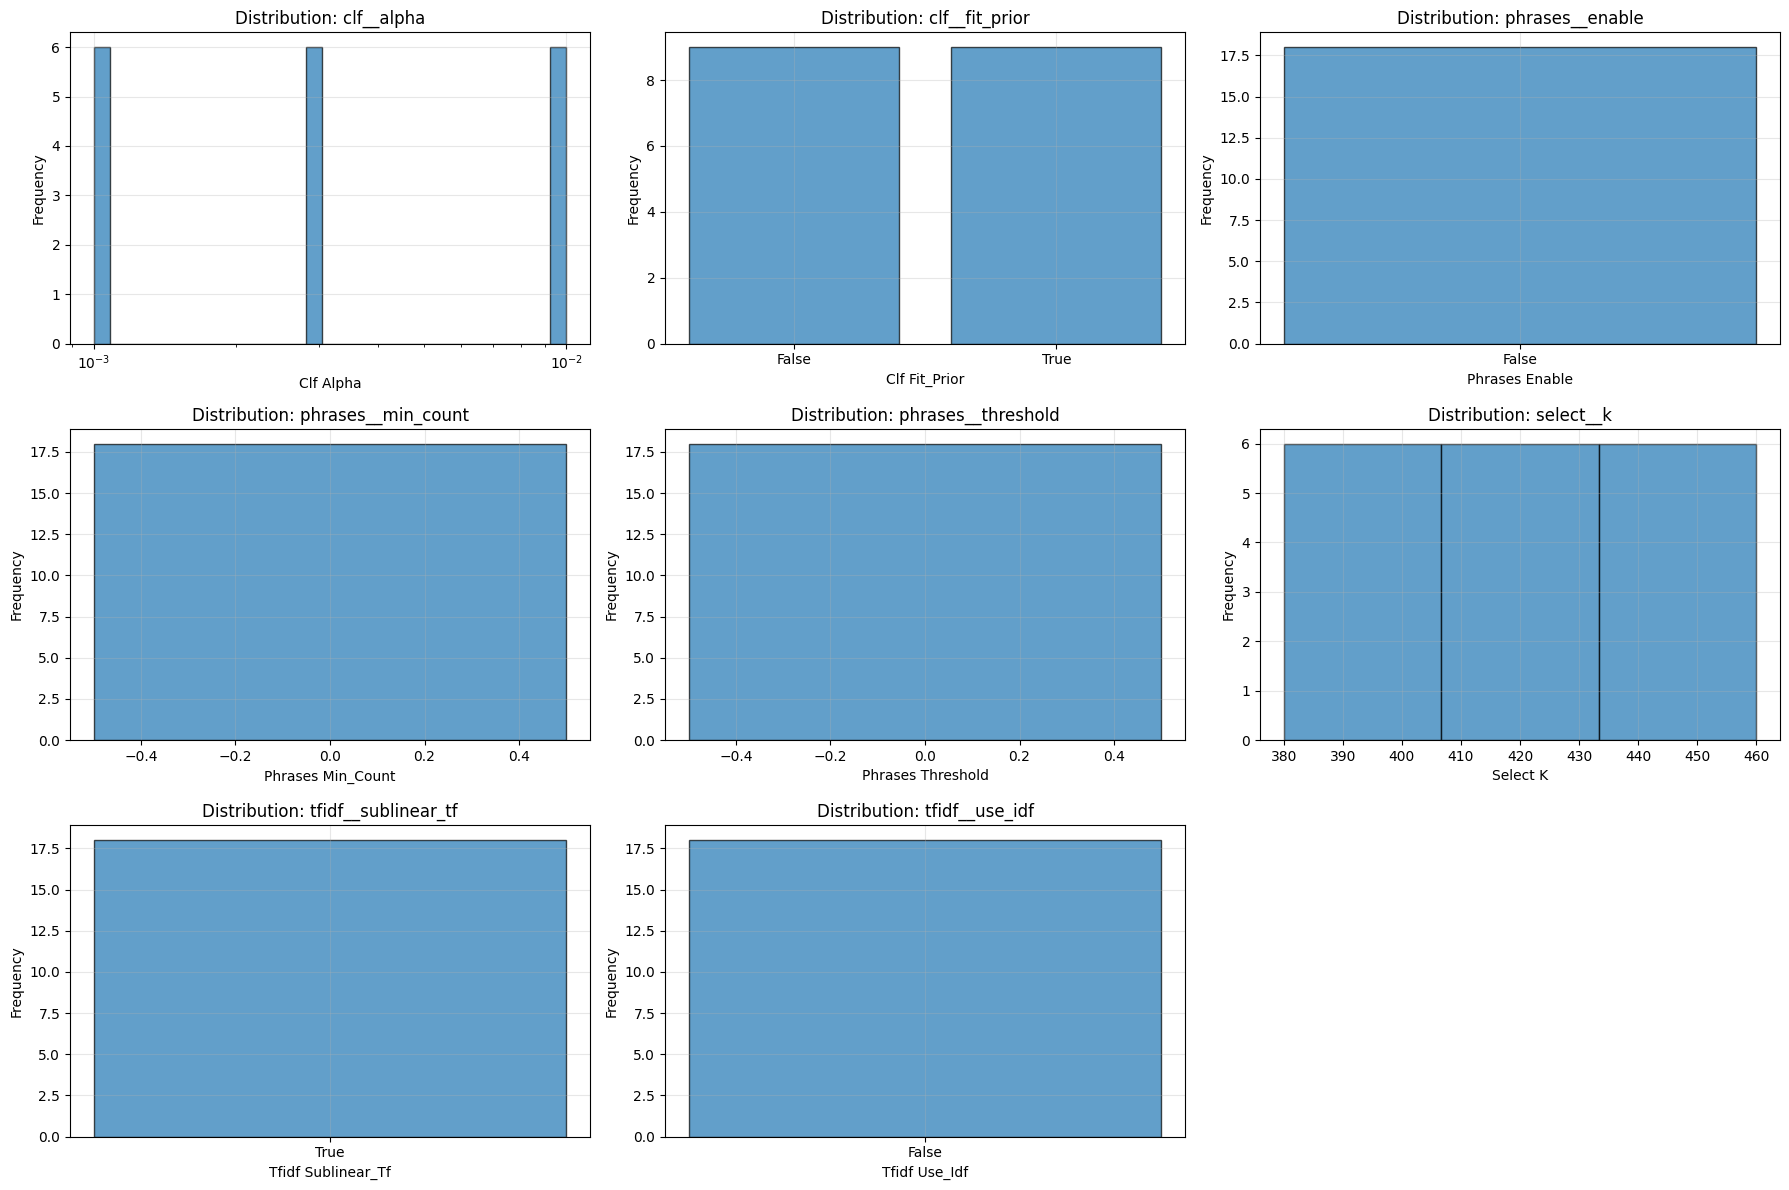


3. Performance vs Individual Parameters:


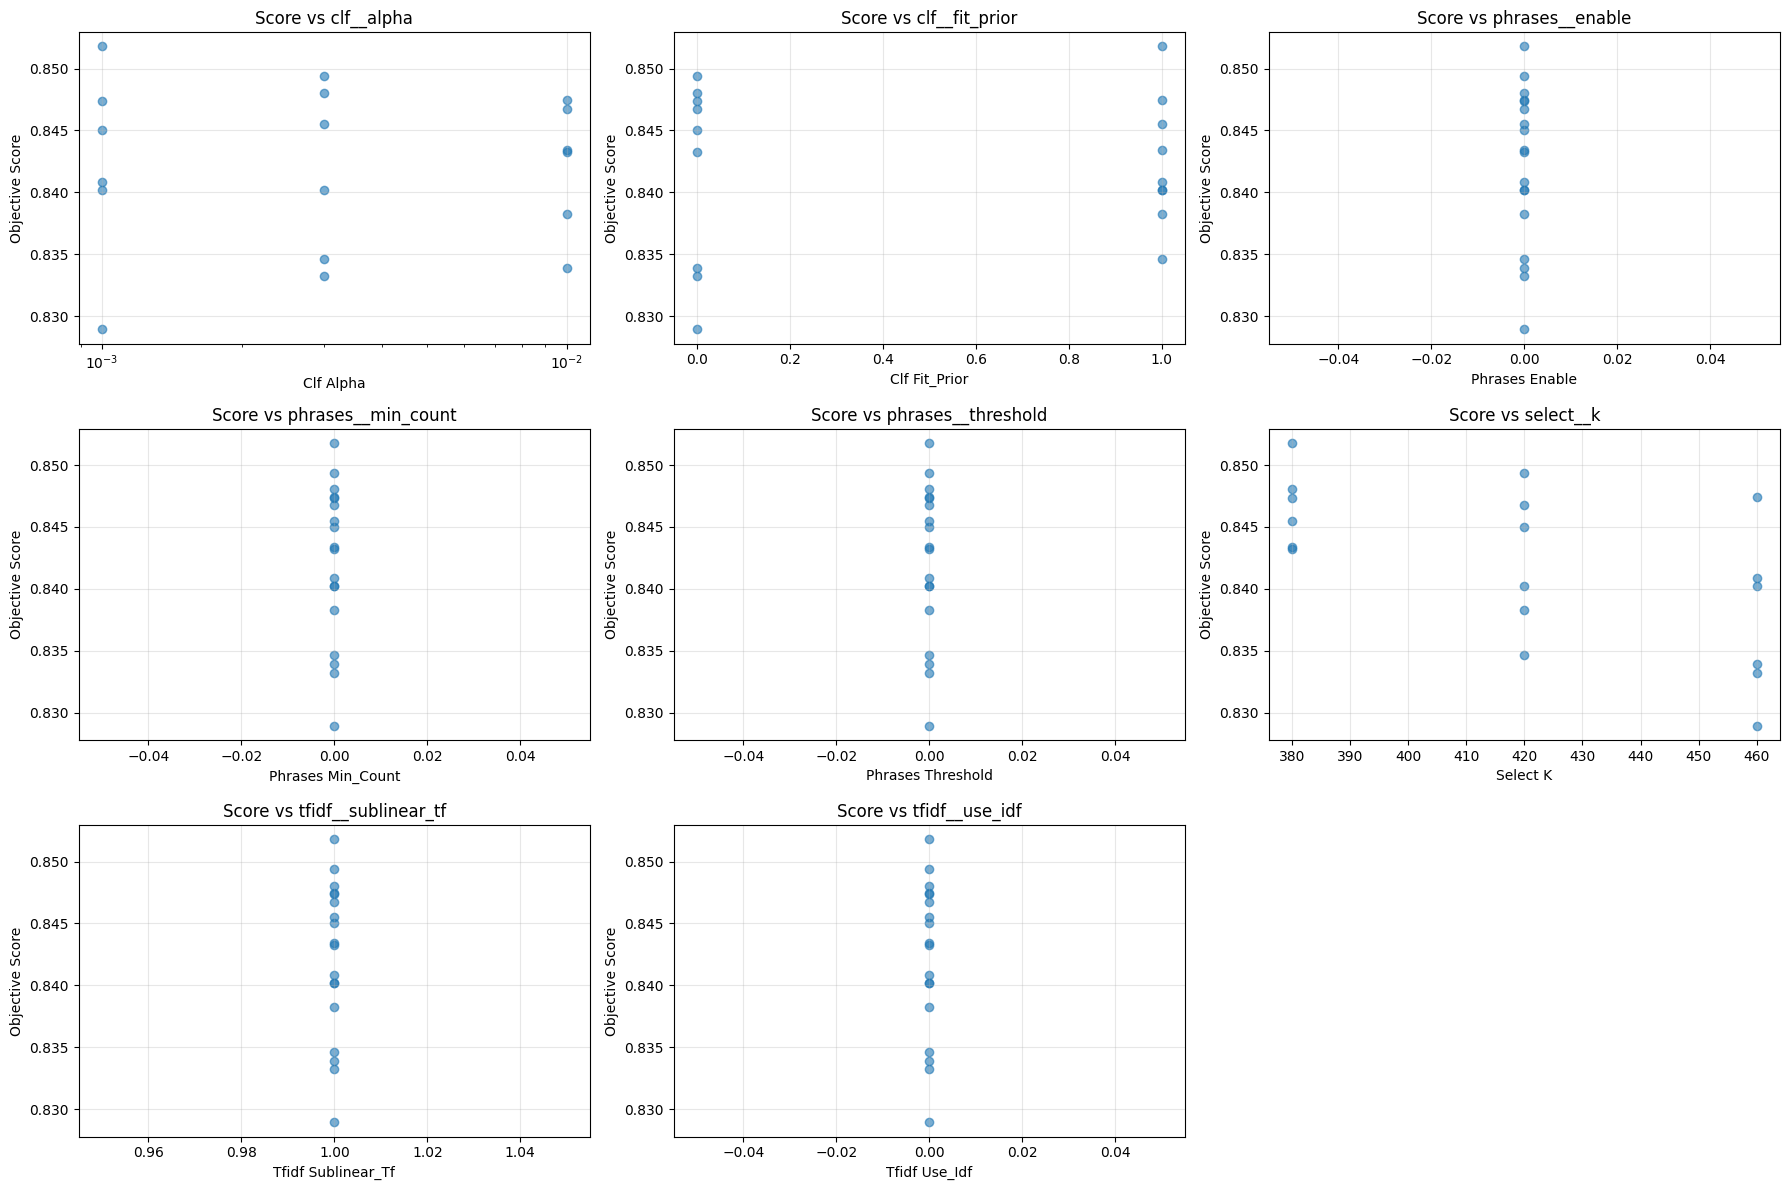


4. Convergence Analysis:


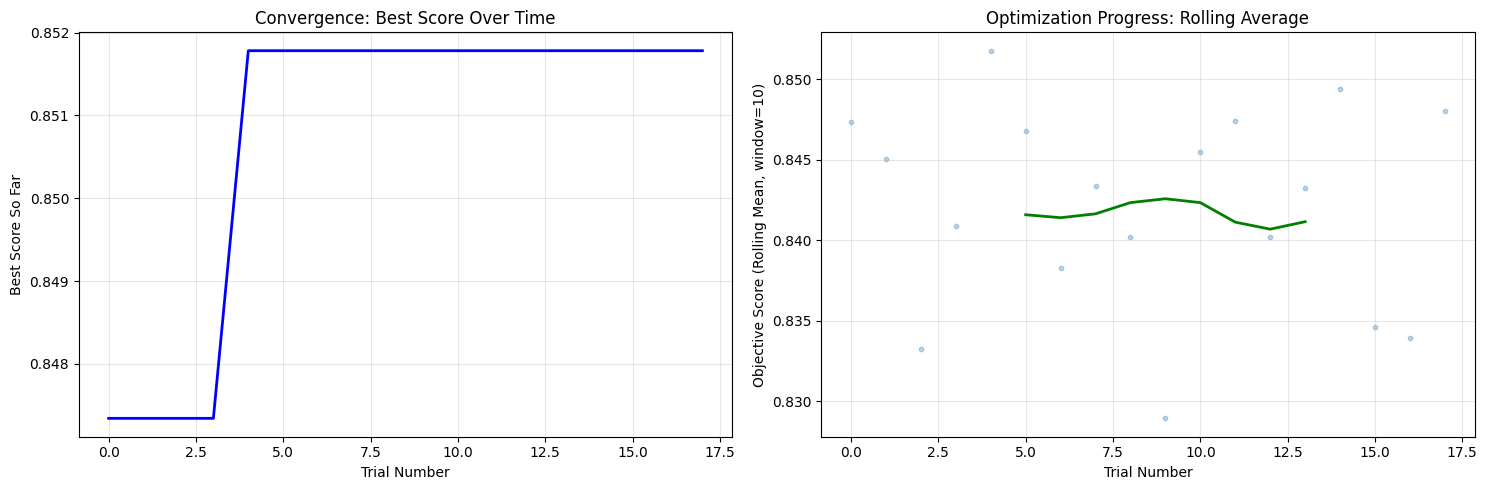


5. Trial Status Overview:


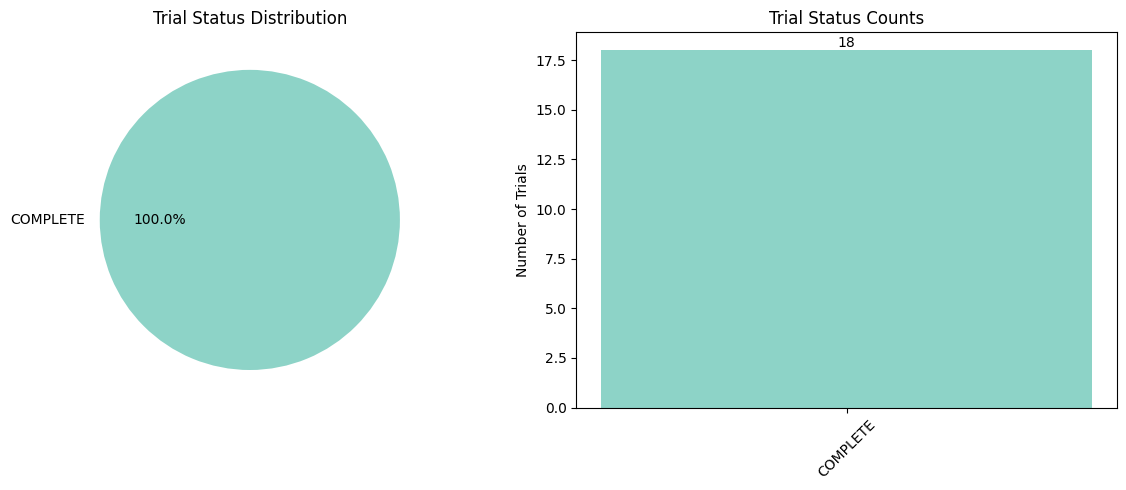


6. Top 10 Best Trials:
Rank Trial#  Score      alpha        fit_prior    enable       min_count    threshold    k            sublinear_tf use_idf     
-------------------------------------------------------------------------------------------------------------------------------
1    4       0.8518     0.0010       True         False        0            0            380          True         False       
2    14      0.8494     0.0030       False        False        0            0            420          True         False       
3    17      0.8480     0.0030       False        False        0            0            380          True         False       
4    11      0.8474     0.0100       True         False        0            0            460          True         False       
5    0       0.8473     0.0010       False        False        0            0            380          True         False       
6    5       0.8468     0.0100       False        False        0            0   

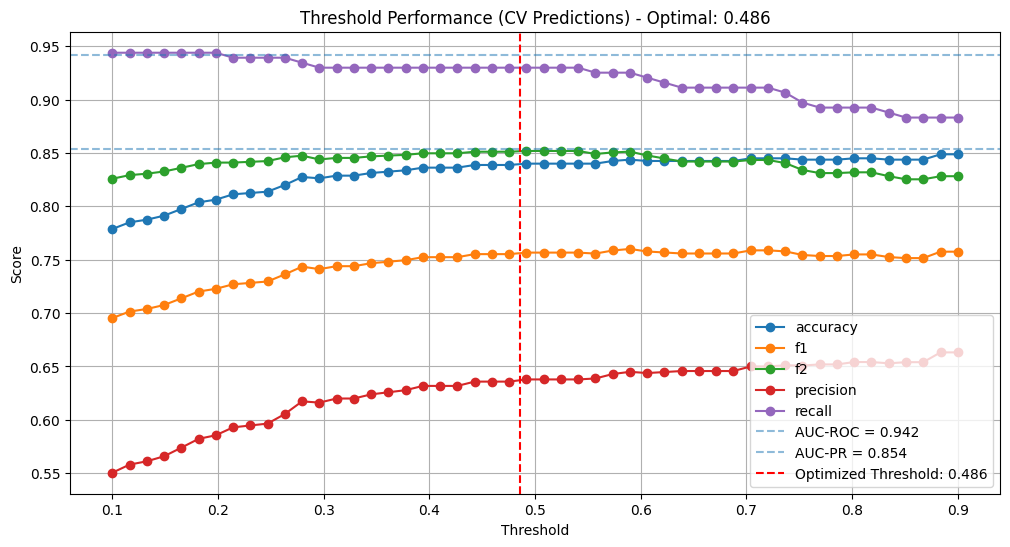

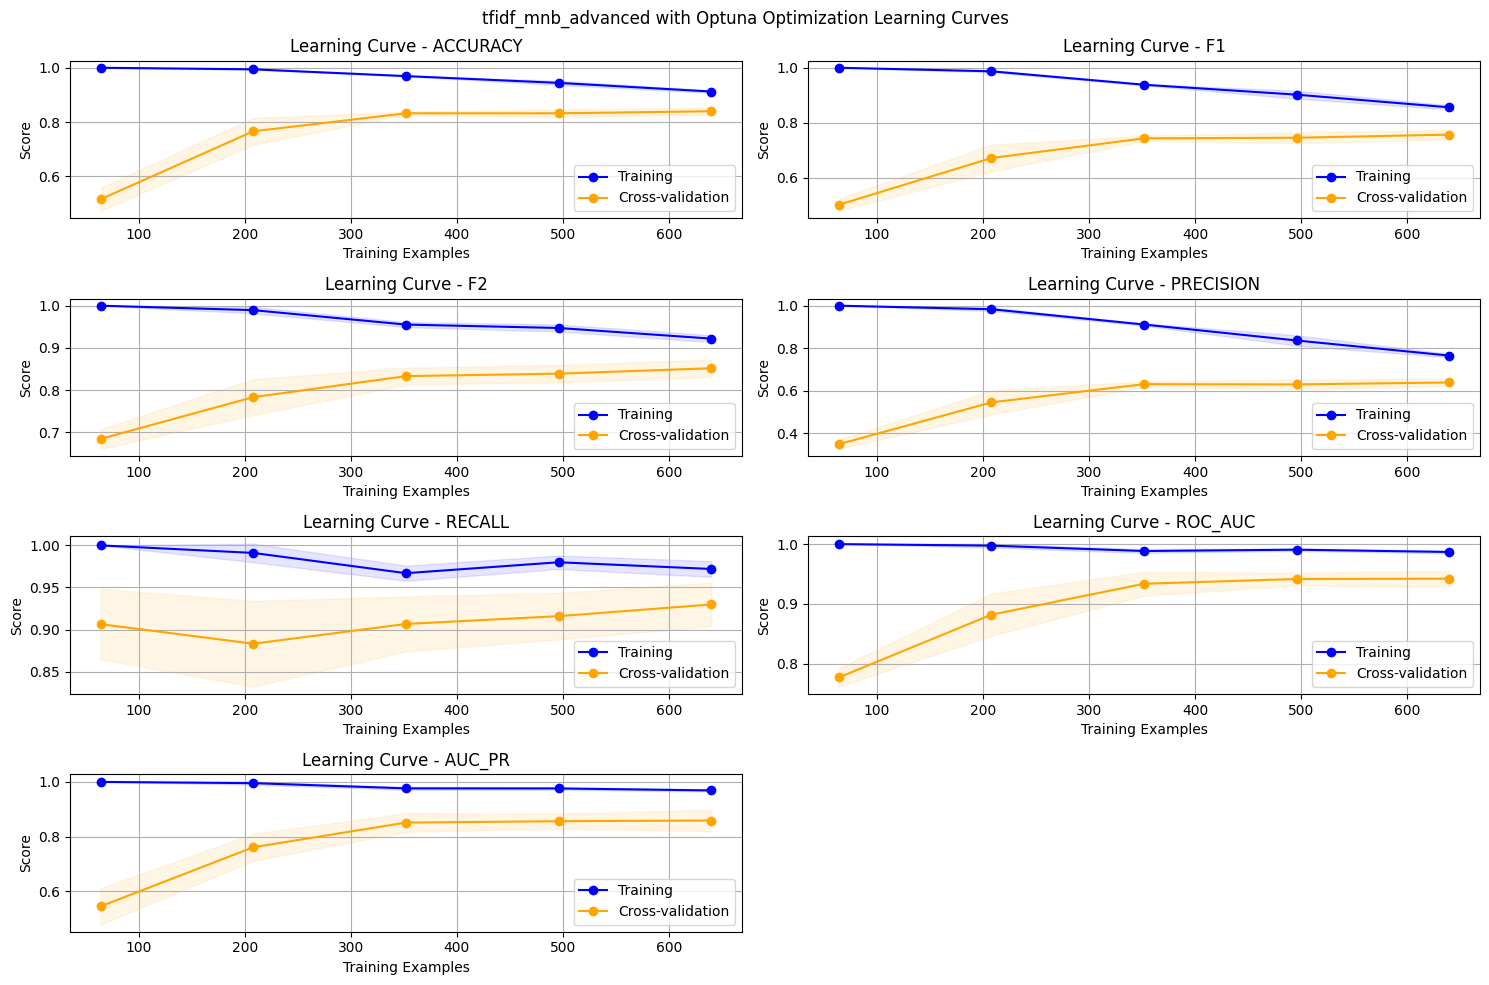


Final Threshold: 0.49
F2-score with default threshold (0.5): 0.851

Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       146
           1       0.68      0.91      0.78        54

    accuracy                           0.86       200
   macro avg       0.82      0.87      0.84       200
weighted avg       0.89      0.86      0.87       200

Additional Metrics:
Accuracy   0.860
F2-score   0.851
AUC-ROC    0.923
AUC-PR     0.849



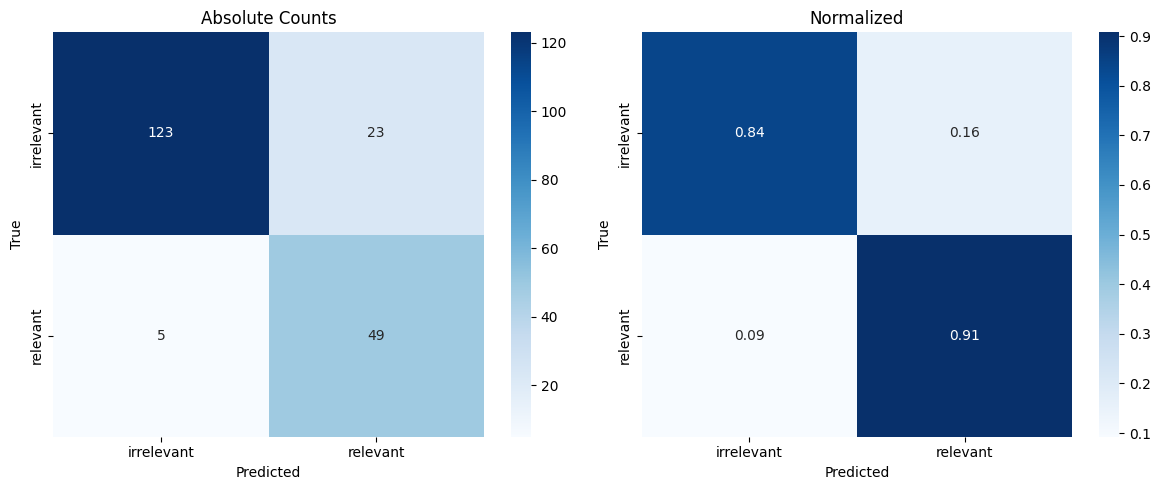

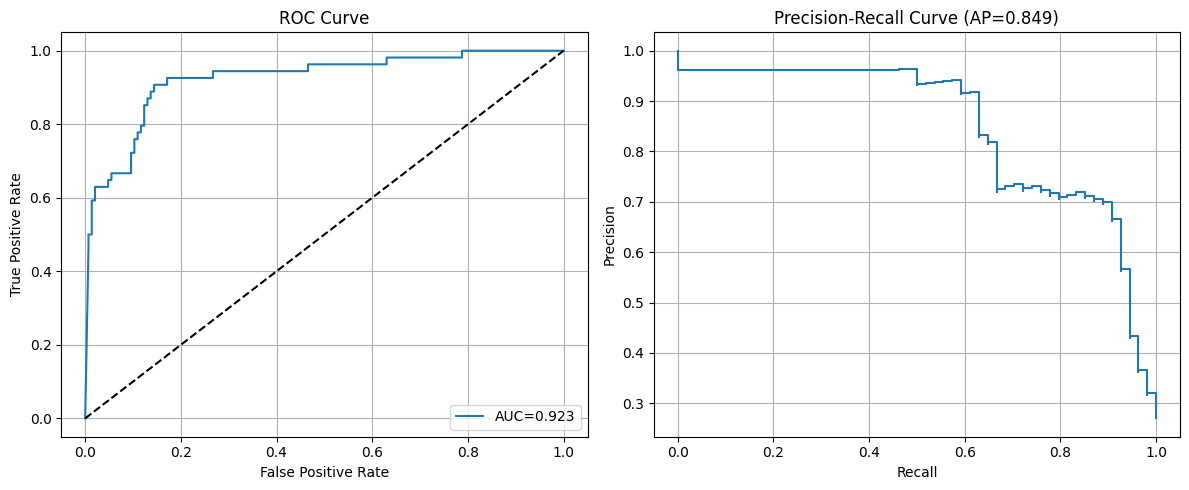


Model saved as model_tfidf_mnb_advanced.joblib


In [28]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a MNB classifier 
pipeline_tfidf_mnb = Pipeline([
    ("phrases", PhraseDetector(enable=False, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True, norm=None, use_idf=False, sublinear_tf=True)), #The multinomial distribution normally requires integer feature counts. sklearn
    ("select",  SelectKBest(score_func=chi2)),
    ("clf",     MultinomialNB(
                    alpha=1.0, #will be optimized during optuna
                    fit_prior=True, #will be optimized during optuna    
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "clf__alpha": [0.001, 0.003, 0.01],          # center on GS best (~0.0035) with one decade below/above to confirm slope
    "select__k": [380, 420, 460],                # tight band around k≈419 where GS peaked
    "clf__fit_prior": [False, True],             # GS best used False; keep True to cheaply validate it isn’t equal/better
    "tfidf__use_idf": [False],                   # all top rows used raw TF (IDF hurt MNB here) → lock
    "tfidf__sublinear_tf": [True],               # sublinear_tf was consistently True in leaders → lock
    "phrases__enable": [False],                  # best runs disabled phrases (less feature dilution for MNB) → lock
    "phrases__min_count": [0],                  # irrelevant when phrases disabled; 
    "phrases__threshold": [0],                # irrelevant when phrases disabled; 
}

model_name = "tfidf_mnb_advanced"

#for second search with grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_tfidf_mnb,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")

best one yet

Best parameters found by Optuna TPE: {'alpha': 4.69967082461246e-06, 'fit_prior': True, 'select__k': 179, 'tfidf_use_idf': False, 'tfidf_sublinear_tf': True, 'phrases__enable': False, 'phrases__min_count': 8, 'phrases__threshold': 220.10285798456792}
Best F2 score during optimization: 0.855

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


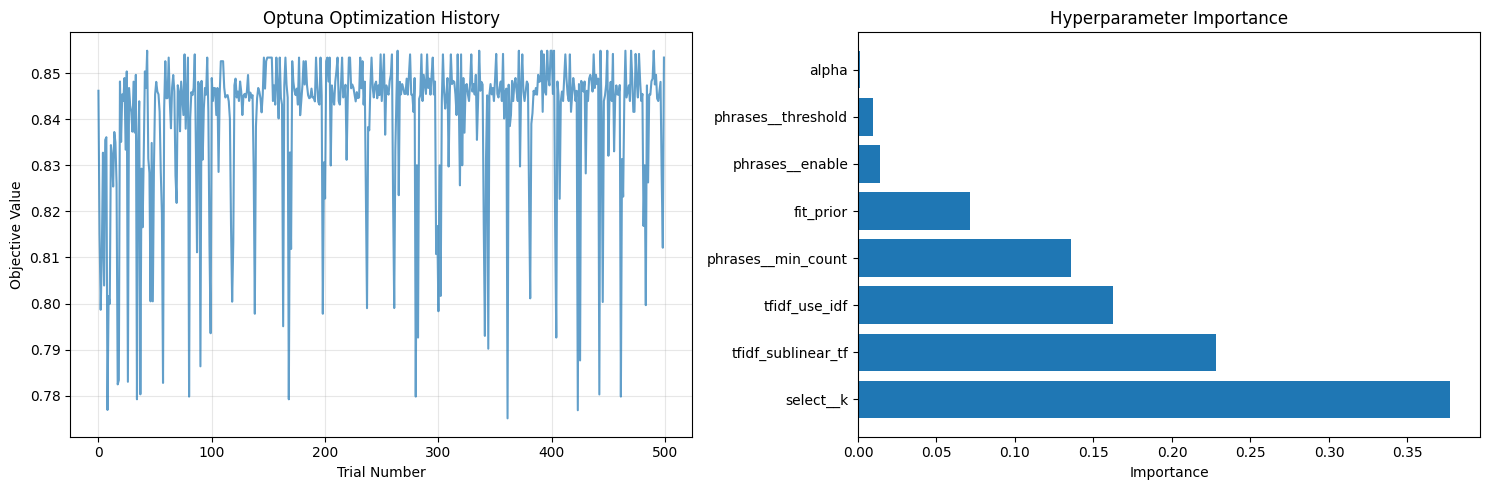


2. Parameter Value Distributions:


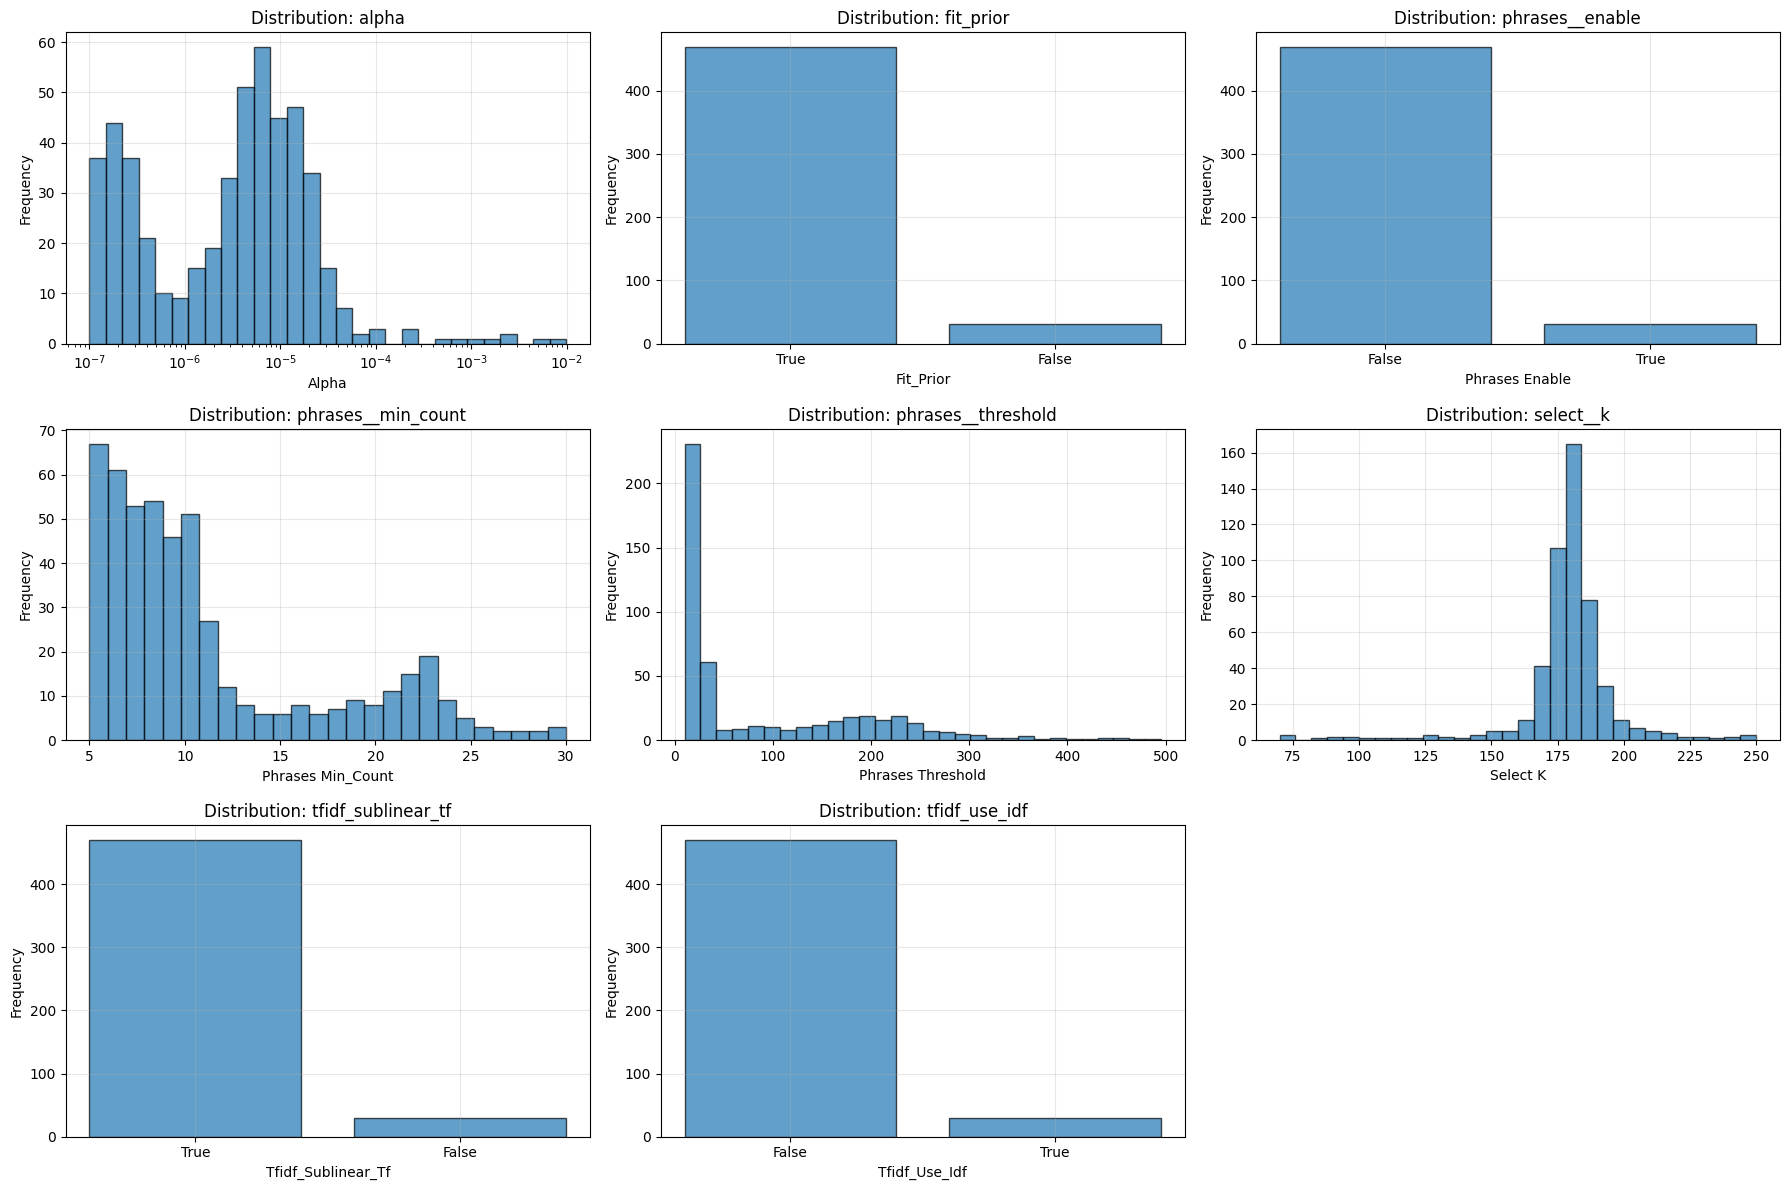


3. Performance vs Individual Parameters:


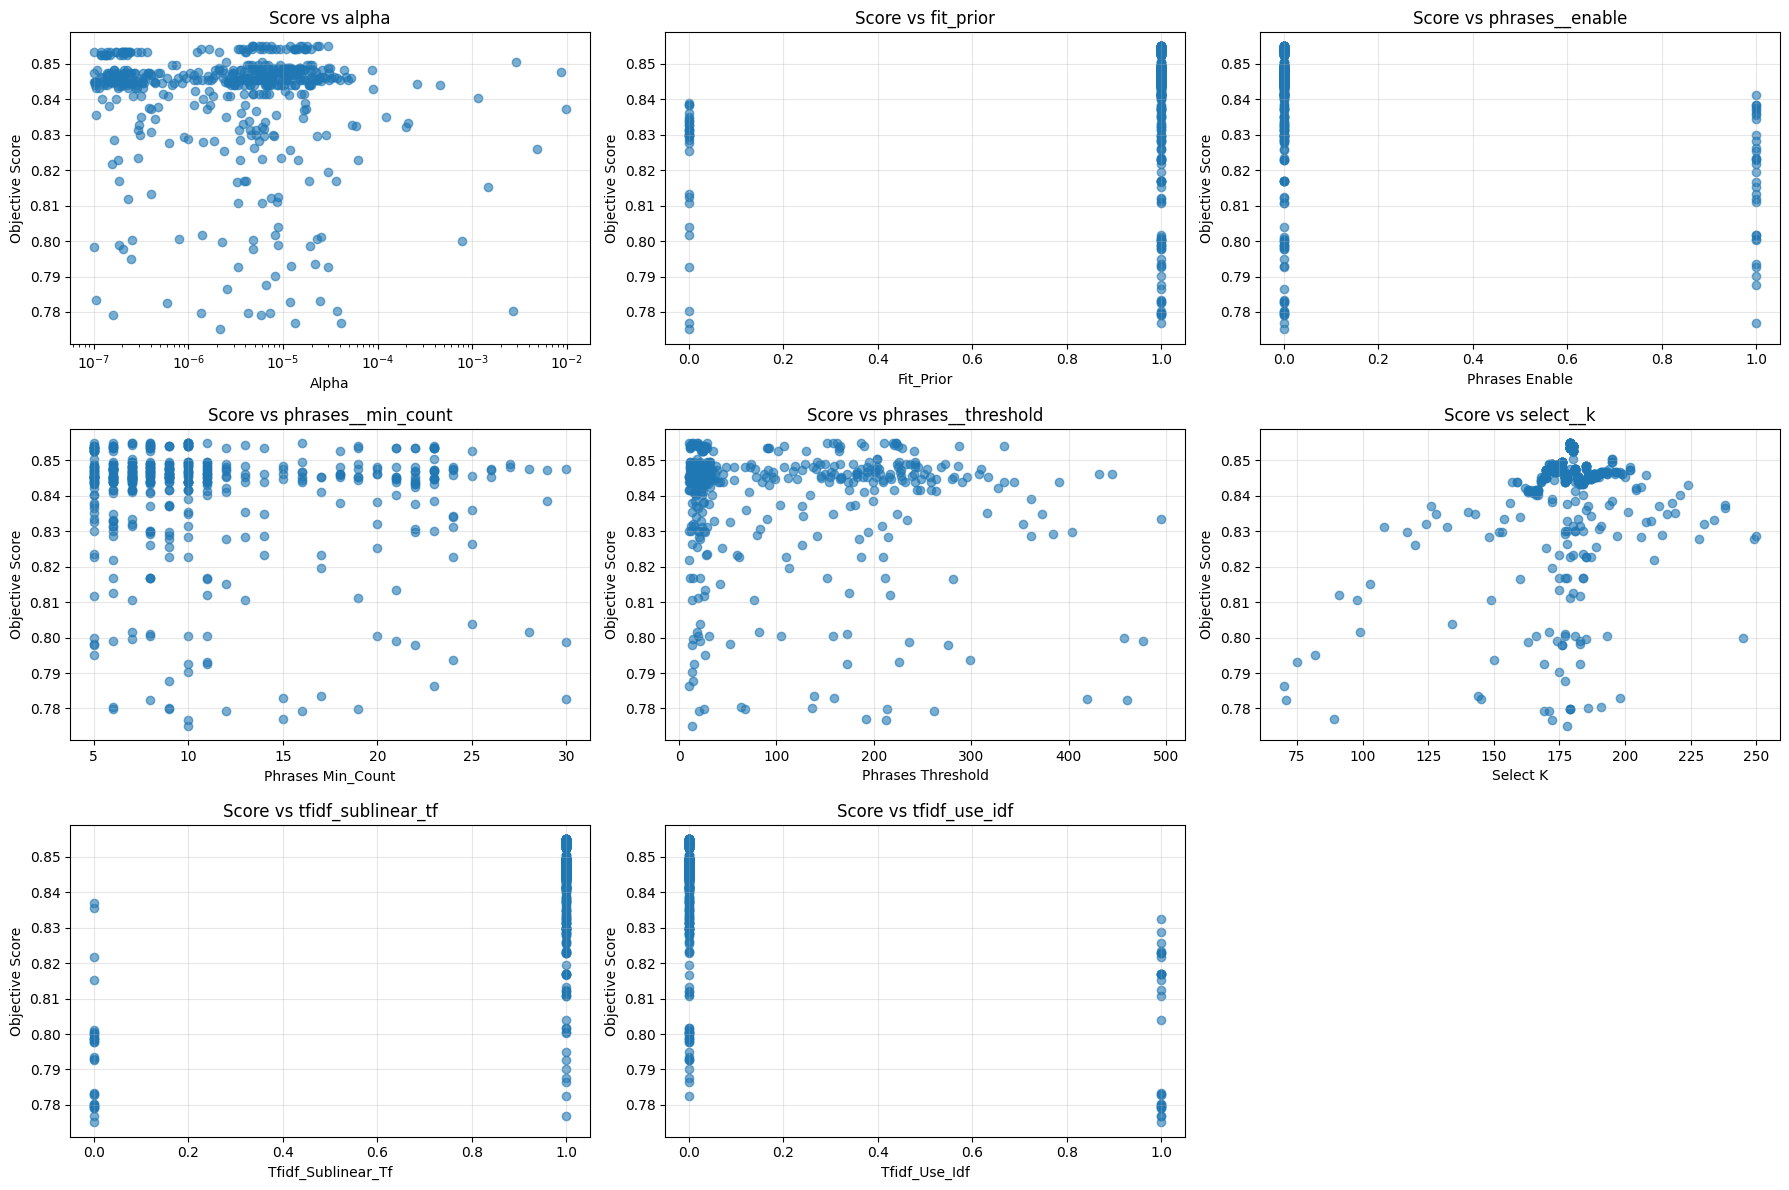


4. Convergence Analysis:


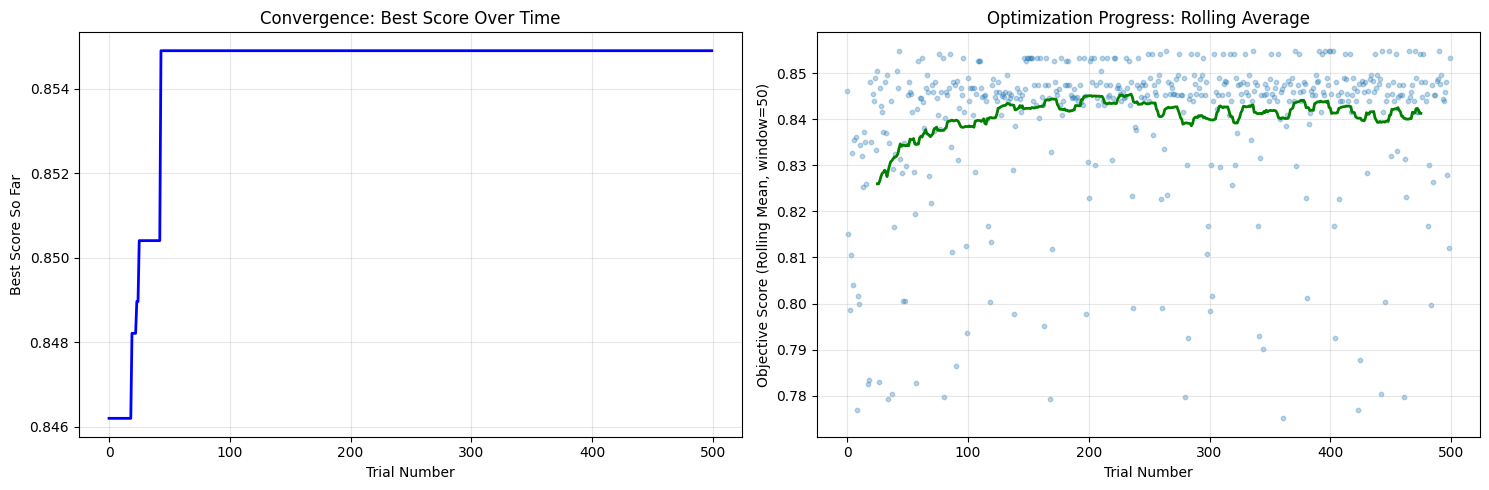


5. Trial Status Overview:


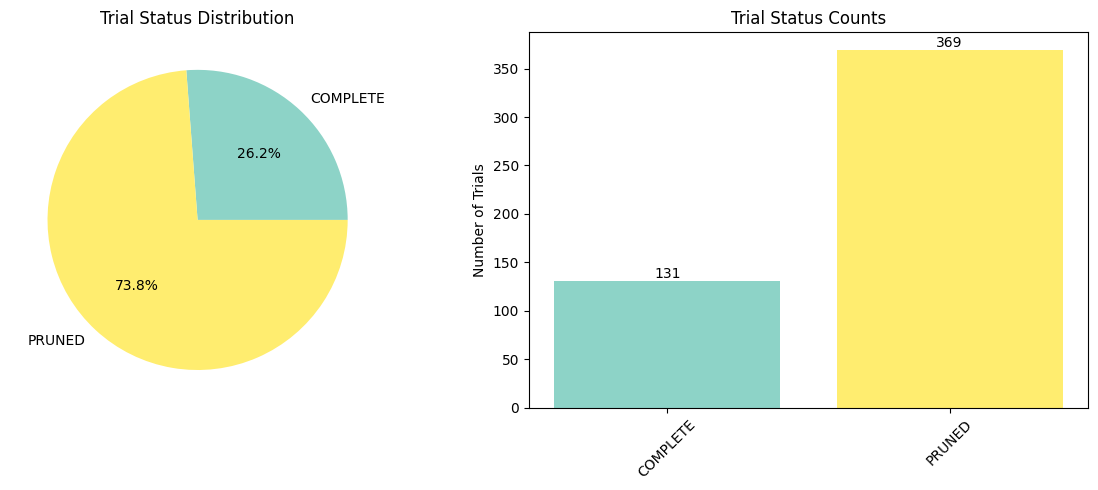


6. Top 10 Best Trials:
Rank Trial#  Score      alpha        fit_prior    enable       min_count    threshold    k            tfidf_sublinear_tf tfidf_use_idf
--------------------------------------------------------------------------------------------------------------------------------------
1    43      0.8549     0.0000       True         False        8            220.1029     179          True         False       
2    264     0.8549     0.0000       True         False        5            28.3212      179          True         False       
3    336     0.8549     0.0000       True         False        11           14.5165      179          True         False       
4    371     0.8549     0.0000       True         False        8            210.6007     179          True         False       
5    391     0.8549     0.0000       True         False        10           186.6536     179          True         False       
6    396     0.8549     0.0000       True         False        10 

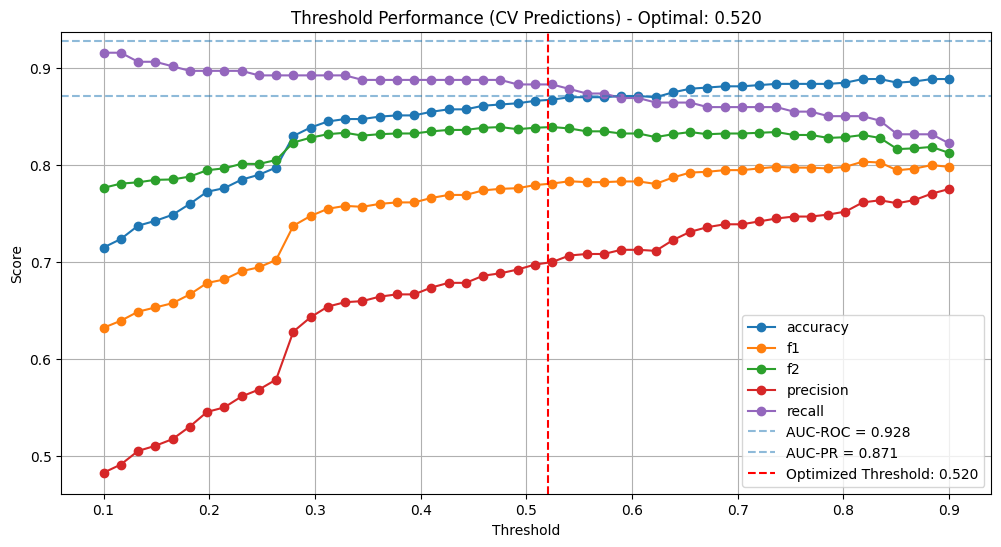

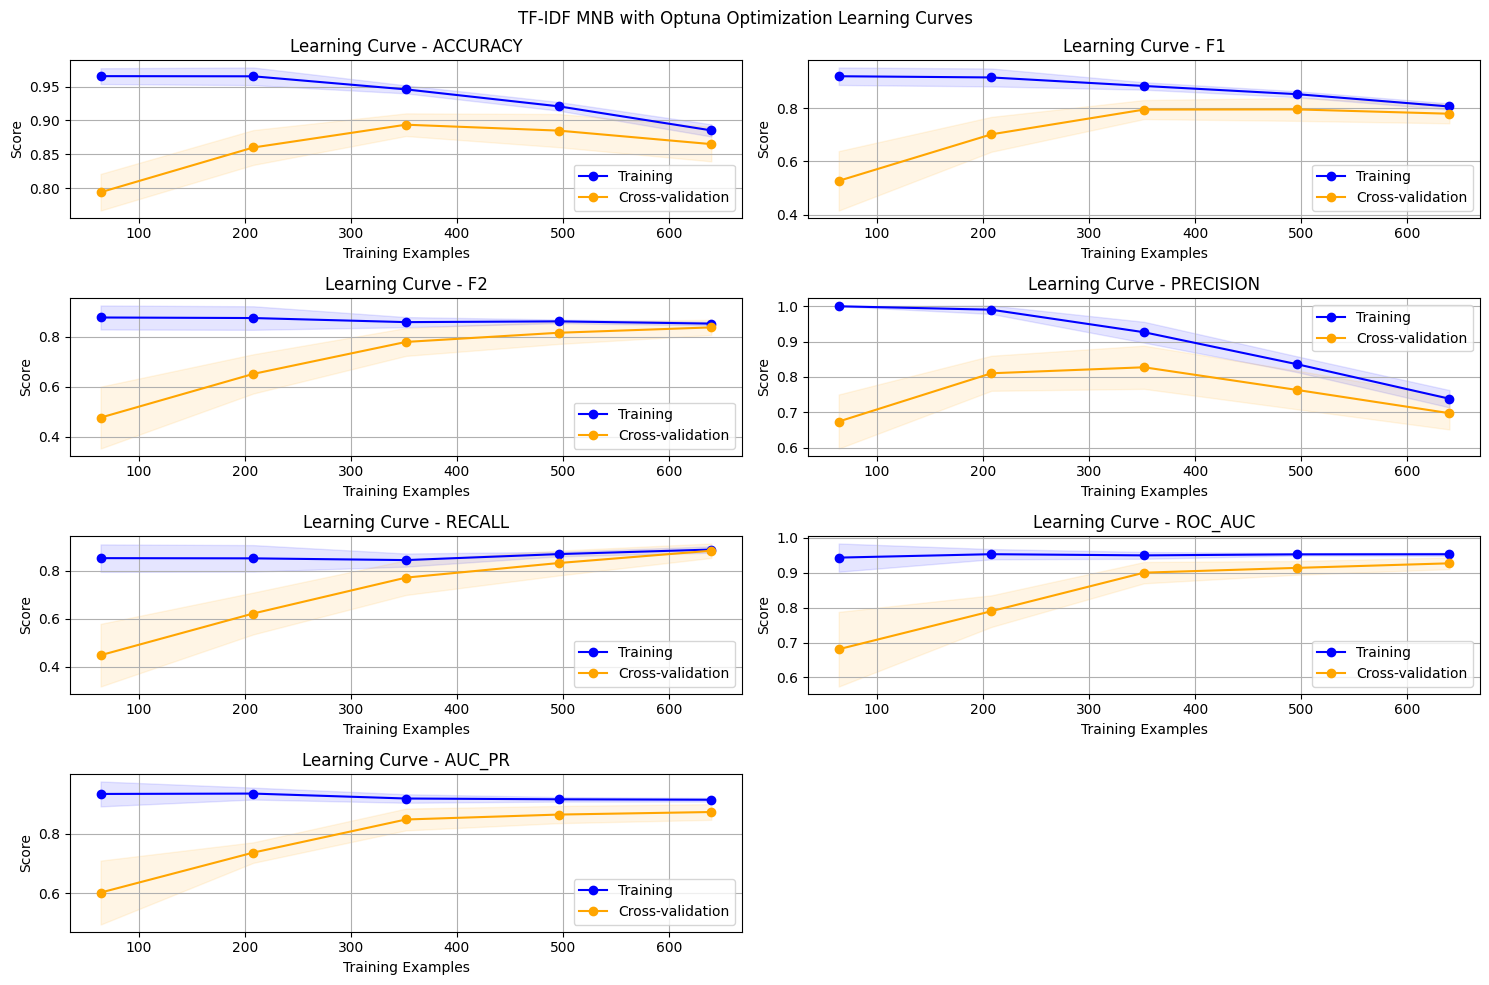


Final Threshold: 0.52

Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       146
           1       0.72      0.91      0.80        54

    accuracy                           0.88       200
   macro avg       0.84      0.89      0.86       200
weighted avg       0.90      0.88      0.88       200

Additional Metrics:
Accuracy   0.880
F2-score   0.863
AUC-ROC    0.931
AUC-PR     0.870



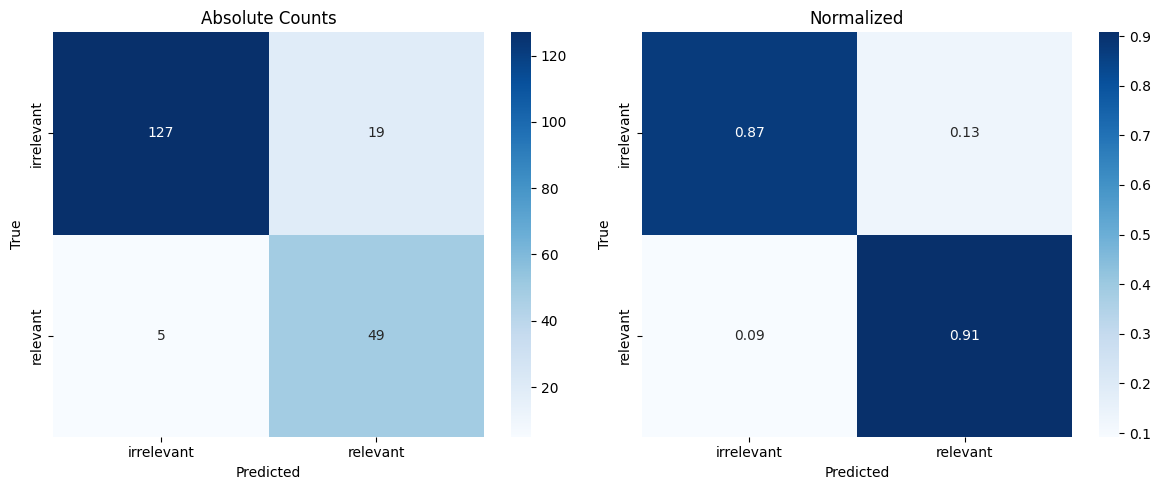

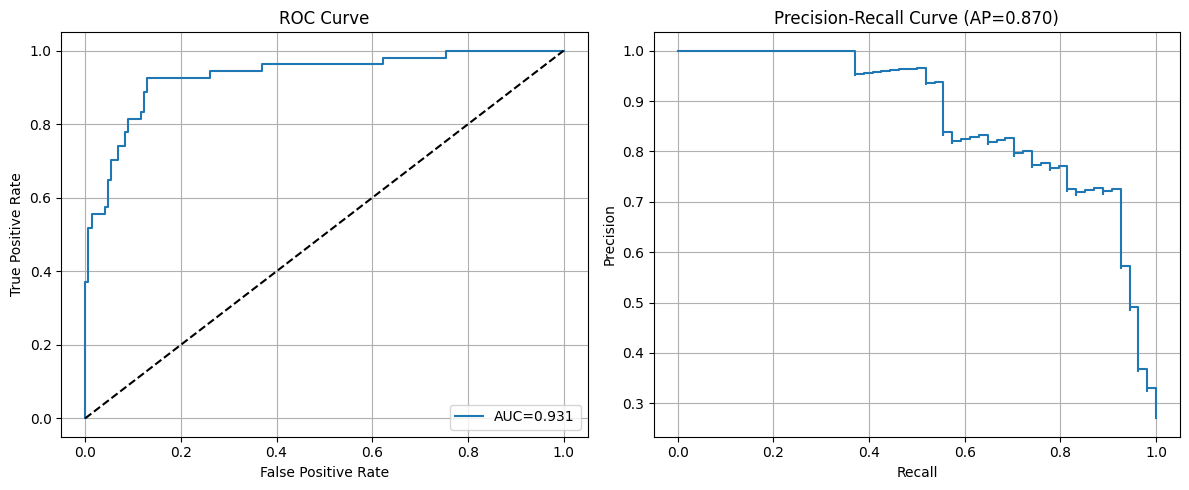


Model saved as 'model_tfidf_mnb_advanced.joblib'


In [14]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a MNB classifier 
pipeline_tfidf_mnb = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True, norm=None, use_idf=False, sublinear_tf=True)), #The multinomial distribution normally requires integer feature counts. sklearn
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     MultinomialNB(
                    alpha=1.0, #will be optimized during optuna
                    fit_prior=True, #will be optimized during optuna    
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter space for Optuna optimization
param_space = {
    "clf__alpha": lambda trial: trial.suggest_float("alpha", 1e-7, 1e-2, log=True),
    "clf__fit_prior": lambda trial: trial.suggest_categorical("fit_prior", [True, False]),
    "select__k": lambda trial: trial.suggest_int("select__k", 70, 250),
    "tfidf__use_idf":      lambda t: t.suggest_categorical("tfidf_use_idf", [False, True]),
    "tfidf__sublinear_tf": lambda t: t.suggest_categorical("tfidf_sublinear_tf", [False, True]),
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [True, False]),
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 5, 30),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 10.0, 500.0, log=True)
}

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna(
    estimator=pipeline_tfidf_mnb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    n_trials=500,  # Intelligent search with early stopping
    direction="maximize",
    n_jobs=-1,
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name="tfidf_mnb_advanced"
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF MNB with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1] #predict_proba available for MNB

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1] #predict_proba available for MNB
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': 'TF-IDF + MNB',
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, "model_tfidf_mnb_advanced.joblib")

print(f"\nModel saved as 'model_tfidf_mnb_advanced.joblib'")